## Load packages

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import csv

## Load and show data

### Matrices


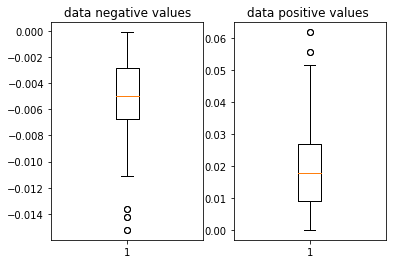

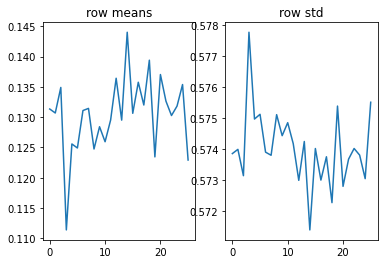

<Figure size 432x288 with 0 Axes>

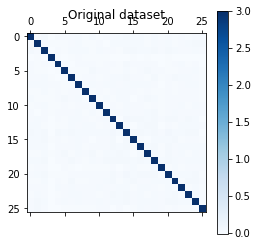

In [2]:
# Load CSV files
ISC_EEG = np.genfromtxt(os.path.join('ISC_EEG.csv'),delimiter=',')
ISC_EEG = np.array(ISC_EEG,dtype='float') # Convert into array

ISC_EDA = np.genfromtxt(os.path.join('ISC_EDA.csv'),delimiter=',')
ISC_EDA = np.array(ISC_EDA,dtype='float') # Convert into array

ISC_IBI = np.genfromtxt(os.path.join('ISC_IBI.csv'),delimiter=',')
ISC_IBI = np.array(ISC_IBI,dtype='float') # Convert into array

# Seeing if negative data have same order of magnitude as positive data 
def orderOfMagnitude(matrix):
    for i in range(len(matrix)):
        matrix[i,i] = 0
    
    neg = matrix[matrix<0]
    plt.subplot(121)
    plt.boxplot(neg)
    plt.title("data negative values")
    
    pos = matrix[matrix>0]
    plt.subplot(122)
    plt.boxplot(pos)
    plt.title("data positive values ")
    
# Remove outlier in array if we find one
def removeOutlierArray(matrix,subject):
    new_mat = np.copy(matrix)
    new_mat = np.delete(new_mat, (subject), axis=0)
    new_mat = np.delete(new_mat, (subject), axis=1)
    
    with open(os.path.join('ISC_truncated.csv'), 'w') as File:
        writer = csv.writer(File,delimiter =';')
        writer.writerows(matrix)
    
    return new_mat

# Remove outlier in vector if we find one
def removeOutlierVector(vector,subject):
    new_vect = np.copy(vector)
    new_vect = np.delete(new_vect, (subject), axis=0)
    return new_vect

# Remove outlier in points if we find one
def removeOutlierPoints(points,subject):
    new_points = np.copy(points)
    new_points = np.delete(new_points, (subject), axis=0)
    
    return new_points

# Remove Inf in data for EDA and IBI (replace by sort of normalisation for the moment)
tmp_EEG = np.copy(ISC_EEG)
tmp_EDA = np.copy(ISC_EDA)
tmp_IBI = np.copy(ISC_IBI)

for i in range(len(tmp_EEG)):
    tmp_EEG[i,i] = 0
    tmp_EDA[i,i] = 0
    tmp_IBI[i,i] = 0
eegNorm = 3/np.mean(tmp_EEG)

for i in range(len(ISC_IBI)):
    ISC_IBI[i,i] = np.mean(tmp_IBI)*eegNorm
    ISC_EDA[i,i] = np.mean(tmp_EDA)*eegNorm
        
# Choose matrix to study
case = 'EEG'
removeOutlier = False # Remove outliers if there are some

if (case == 'EEG'):
    if (removeOutlier): # Remove outliers if there are some
        ISC_EEG = removeOutlierArray(ISC_EEG,3) # Really outlier?
    study_matrix = ISC_EEG
elif (case == 'EDA'):
    if (removeOutlier): # Remove outliers if there are some
        #ISC_EDA = removeOutlierArray(ISC_EDA,12) # Really outlier?
        #ISC_EDA = removeOutlierArray(ISC_EDA,20) # Really outlier?
        ISC_EDA = removeOutlierArray(ISC_EDA,17)
    study_matrix = ISC_EDA
elif (case == 'IBI'):
    if (removeOutlier): # Remove outliers if there are some
        print("Haven't found any outliers for the moment")
        # ISC_IBI = removeOutlierArray(ISC_IBI,)
    study_matrix = ISC_IBI

N = len(study_matrix)

# Boxplot
orderOfMagnitude(np.copy(study_matrix))

# Normalize rows and columns ?
    
# Remove negative values from EDA and IBI
#study_matrix = np.where(study_matrix>0,study_matrix,0)

plt.figure()
plt.subplot(121)
plt.plot(np.mean(study_matrix,axis=0))
plt.title('row means')
plt.subplot(122)
plt.plot(np.std(study_matrix,axis=0))
plt.title('row std')

# Show matrix data
plt.figure()
plt.matshow(study_matrix, cmap=plt.cm.Blues)
plt.title("Original dataset")
plt.colorbar()
plt.show()

### True groups

In [3]:
# Load true clusters
condition = np.genfromtxt(os.path.join('condition.csv'),delimiter=',')
condition = np.array(condition,dtype='int') # Convert into array
if (removeOutlier): # Remove outliers if there are some
    if (case == 'EEG'):
        condition = removeOutlierVector(condition,3) # Really outlier?
    elif (case == 'EDA'):
        #condition = removeOutlierVector(condition,12) # Really outlier?
        #condition = removeOutlierVector(condition,20) # Really outlier?
        condition = removeOutlierVector(condition,17) # Really outlier?
    elif (case == 'IBI'):
        print("Haven't found any outliers for the moment")
        # condition = removeOutlierVector(condition,) # Really outlier?

narrative = np.where(condition == 0)[0]
stimulus = np.where(condition == 1)[0]

#conditionShuffle = np.random.shuffle(np.copy(condition))

'''
narrative = np.array([ 0 , 2 , 4 , 5 , 7 , 9, 11 ,13 ,16 ,17 ,18 ,22 ,25])
stimulus = np.array([ 1,  3,  6 , 8 ,10 ,12 ,14 ,15 ,19 ,20 ,21, 23, 24])
condition = np.genfromtxt(os.path.join('condition.csv'),delimiter=',')
condition = np.array(condition,dtype='int') # Convert into array
conditionShuffle = np.zeros(N)
'''

"\nnarrative = np.array([ 0 , 2 , 4 , 5 , 7 , 9, 11 ,13 ,16 ,17 ,18 ,22 ,25])\nstimulus = np.array([ 1,  3,  6 , 8 ,10 ,12 ,14 ,15 ,19 ,20 ,21, 23, 24])\ncondition = np.genfromtxt(os.path.join('condition.csv'),delimiter=',')\ncondition = np.array(condition,dtype='int') # Convert into array\nconditionShuffle = np.zeros(N)\n"

### Compute distance matrix

In [4]:
# rank of elements 
def rankify(A): 
  
    # Rank Vector 
    R = [0 for x in range(len(A))] 
  
    # Sweep through all elements 
    # in A for each element count 
    # the number of less than and  
    # equal elements separately 
    # in r and s. 
    for i in range(len(A)): 
        (r, s) = (1, 1) 
        for j in range(len(A)): 
            if j != i and A[j] < A[i]: 
                r += 1
            if j != i and A[j] == A[i]: 
                s += 1       
         
        # Use formula to obtain rank 
        R[i] = r + (s - 1) / 2
  
    # Return Rank Vector 
    return R

In [5]:
import scipy.spatial.distance as ssd

def computeDistanceMatrix(normalisation=1,addCoef=0,uncondensed=False,euclideanTransform=True,finalNorm=False,rank=False,keepDiag=True,study_matrix=study_matrix): # Choose normalisation between 1 and 45, 
                                            # 45 means bigger non diagonal correlations almost 1
    matrix_norm = np.copy(study_matrix)
    if (keepDiag==False):
        for i in range(len(study_matrix)):
            matrix_norm[i,i] = 0
    maxi = np.max(abs(matrix_norm)) # Max value except from the diagonal

    for i in range(len(study_matrix)):
        matrix_norm[i,i] = maxi*normalisation

    # Normalise max value to 1
    matrix_norm = matrix_norm / np.max(abs(matrix_norm))

    # Convert into distance matrix
    if (euclideanTransform):
        distance_matrix = np.sqrt(2*N*(1-matrix_norm))
        # distance_matrix = np.sqrt((1-matrix_norm)) # Formula in Matlab and in Scikit (?) to convert 
    else:
        distance_matrix = 1-matrix_norm
        
    # Check if bad construction
    for i in range(len(study_matrix)):
        if (distance_matrix[i,i]!=0):
            raise ValueError('Bad construction of distance matrix, not zero on diagonal')
            
    tmp_distance_matrix = np.copy(distance_matrix)
    
    for i in range(len(study_matrix)):
        tmp_distance_matrix[i,i]=1 # Change diagonal to be different from zero
    if (np.min(tmp_distance_matrix)==0):
        raise ValueError('Bad construction of distance matrix, zero outside diagonal')
        #print('Bad construction of distance matrix, zero outside diagonal')
    
    # Normalisation to avoid negative eigen values in PCoA
    distance_matrix = distance_matrix + addCoef
    for i in range(len(study_matrix)):
        distance_matrix[i,i] = 0
    
    # Transform matrix into uncondensed matrix
    if (uncondensed):
        distance_matrix = ssd.squareform(distance_matrix)
        
    # Transform matrix into rank matrix
    if (rank):
        rank_matrix = np.zeros_like(distance_matrix)
        for i in range(len(study_matrix)):
            rank_matrix[i,:] = rankify(distance_matrix[i,:])
        return rank_matrix
        
    ## Write new CSV file with all data
    if (uncondensed==False):
        with open(os.path.join('dist_'+ case + '.csv'), 'w') as File:
            writer = csv.writer(File,delimiter =';')
            writer.writerows(distance_matrix)
            
    if (finalNorm):
        distance_matrix = distance_matrix / np.std(distance_matrix) 

    return distance_matrix
    
'''
# Normalise data
for i in range(N):
    matrix[:,i] = (matrix[:,i] - np.mean(matrix[:,i])) / np.std(matrix[:,i])
'''

'\n# Normalise data\nfor i in range(N):\n    matrix[:,i] = (matrix[:,i] - np.mean(matrix[:,i])) / np.std(matrix[:,i])\n'

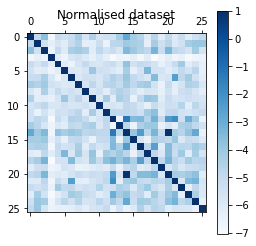

In [6]:
norm_coef = 1
add_coef = 0
distance_matrix = computeDistanceMatrix(1.0001,addCoef=0,keepDiag=False) # Choose between 1 and 45, 
                                            # 45 means bigger non diagonal correlations almost 1

study_matrix_norm = 1-(distance_matrix-add_coef)
for i in range(len(study_matrix)):
    study_matrix_norm[i,i] = 1

plt.matshow(study_matrix_norm, cmap=plt.cm.Blues)
plt.title("Normalised dataset")
plt.colorbar()
plt.show()

### Silhouette coefficient (SC)

In [7]:
from sklearn.metrics import silhouette_score

# Compute DB-score based on distance matrix(small means good clustering)
def silhouetteCoef(distance_matrix,label,metric='precomputed'):
    if len(np.unique(label))==1:
        warnings.warn("Labels correspond to only 1 group")
        return -1
    else:
        return silhouette_score(distance_matrix, label, metric=metric)

accuracyVect = np.array([])
SCVect = np.array([])
methodUsed = np.array([])
prior = np.array([])

## Bloc modelling / Bi-clustering

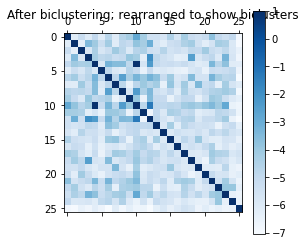

In [8]:
from sklearn.cluster import SpectralCoclustering

# Fit the model
cocluster = SpectralCoclustering(n_clusters=2, random_state=0)
cocluster.fit(study_matrix_norm)
'''
score = consensus_score(model.biclusters_,
                        (rows[:, row_idx], columns[:, col_idx]))

print("consensus score: {:.3f}".format(score))
'''
fit_data = study_matrix_norm[np.argsort(cocluster.row_labels_)]
fit_data = fit_data[:, np.argsort(cocluster.column_labels_)]

# Show results
plt.matshow(fit_data, cmap=plt.cm.Blues)
plt.title("After biclustering; rearranged to show biclusters")
plt.colorbar()
plt.show()

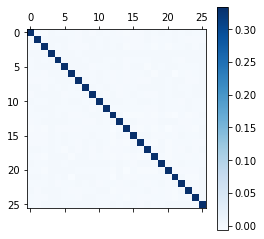

In [9]:
# Show matrix inverse (decorrelation?)
decorr = np.linalg.inv(study_matrix)

plt.matshow(decorr, cmap=plt.cm.Blues)
plt.colorbar()
plt.show()

## Defining result class

In [10]:
from sklearn.metrics import davies_bouldin_score
import warnings

class Results():

    def __init__(self,name,random_init,sslLabel=None,n_neighbors=3,condition=condition):
        self.accuracy = np.zeros((N,len(coefficients)))
        self.best_accuracy = 0
        self.best_dim = 0
        self.best_norm = 0
        self.label = np.zeros(N)
        self.probaLabel = np.zeros(N)
        self.wellClassified = None
        self.misClassified = None
        self.name = name
        self.random_init = random_init
        self.best_points = None
        self.SC = -1
        self.sslLabel = sslLabel
        self.allLabel = []
        self.n_neighbors = n_neighbors
        self.condition = condition
        
    def thresholdLabel(self):
        self.label = np.where(self.probaLabel<0.5,0,1)
        self.accuracy = sum(self.condition==self.label)/N
    
    def initCenters(self,NA_ref,SSA_ref,points):
        dim = points.shape[1]
        init = np.zeros((dim,2))
        init[:,0] = np.mean(points[NA_ref,:],axis=0)
        init[:,1] = np.mean(points[SSA_ref,:],axis=0)
        return init.T
        
    def twoClustersMethodResult(self):
        print("Results\n")
        if (random_init==False):
            print("Best dimension %d (7 means t-SNE)" %self.best_dim)
            print("Best normalisation %d " %self.best_norm)
        print("Found clusters ")
        print(self.label)
        print("True clusters ")
        print(self.condition)
        self.trueWrongClusters()
        print("Well classified")
        print(self.wellClassified)
        print("Wrong classified")
        print(self.misClassified)
        self.best_accuracy = np.max(self.accuracy)
        print("Best %s accuracy : %f" %(self.name,self.best_accuracy))
        print("Silhouette coefficient : %0.3f" %self.SC)
        if (self.random_init):
            self.findRobustParticipants()
        
    def trueWrongClusters(self):
        subjects = np.arange(0,N)
        self.wellClassified = subjects[self.label==self.condition]
        self.misClassified = subjects[self.label!=self.condition]
        
    def findRobustParticipants(self):
        robustness = 0.7
        self.robustLabel = np.where((self.probaLabel<=(1-robustness))+(self.probaLabel>=robustness),1,0)
        print("Robust participants")
        print(self.robustLabel)
        print(subjects[self.robustLabel==1])
        print("Frequencies")
        print(self.probaLabel)
        
    def applyMethod(self,method,dim=np.arange(1,int(N/4)+2),verbose=True):
        if (verbose):
            print("Computing clustering\n")
        for p in range(len(coefficients)):
            if (verbose):
                print(str(int(p*100/len(coefficients))) + "%")
            distance_matrix = computeDistanceMatrix(normalisation=coefficients[p],addCoef=add_coef)

            for i in dim: # Negative means PCoA, 7 means t-SNE, range(1,6) means metric MDS
                self.best_points = np.zeros((N,abs(i)))
                if (isinstance(self,MapMethodResults)):
                    if (i<0):
                        points = computePCoACoordinate(distance_matrix,n_comp=abs(i))
                    elif (i==0):
                        points = computeMVSCCoordinate()
                    elif (i<int(N/4)+1):
                        points,stress,disparities = computeMDSCoordinate(distance_matrix,i)
                    elif (i==7):
                        points = computeSNECoordinate(distance_matrix)
                    elif (i==8):
                        points = computeUMAPCoordinate(distance_matrix,self.sslLabel,n_neighbors=self.n_neighbors)
                    elif (i==10):
                        points = computeMVMDSCoordinate()
                    if hasattr(method, 'init'):
                        if hasattr(method.init, 'shape'):
                            method.init = self.initCenters(NA_HC,SSA_HC,points)
                    if (self.sslLabel is None):
                        meth = method.fit(points)
                    else:
                        meth = method.fit(points,self.sslLabel)
                else:
                    meth = method.fit(distance_matrix)
                    
                if hasattr(meth, 'labels_'):
                    label = meth.labels_
                else:
                    label = meth.predict(points)
                
                '''
                acc = sum(self.condition==label)/N
                if (acc<0.5):
                    label = 1-label
                    self.accuracy[i-1,p] = 1-acc
                else:
                    self.accuracy[i-1,p] = acc
                '''
                label = self.reverseLabel(label)
                acc = sum(self.condition==label)/N
                self.accuracy[i-1,p] = acc
                
                if self.accuracy[i-1,p] == np.max(self.accuracy):
                    self.label = label
                    self.best_dim = i
                    self.best_norm = coefficients[p]
                    if (isinstance(self,MapMethodResults)):
                        self.best_points = points
                        self.SC = silhouetteCoef(self.best_points,self.label,metric='euclidean')
                    else:
                        self.SC = silhouetteCoef(distance_matrix,self.label,metric='precomputed')
        
    def applyMethodAverage(self,method,coef,dim=2,n_run=1,verbose=True):
        print("Computing clustering\n")
        self.best_points = np.zeros((N,dim))
        self.best_dim = dim
        distance_matrix = computeDistanceMatrix(normalisation=coef,addCoef=add_coef)
        for k in range(n_run):
            if (verbose):
                print(str(int(k*100/n_run)) + "%")
            if (isinstance(self,MapMethodResults)):
                if (dim<int(N/4)+1):
                    points = computePCoACoordinate(distance_matrix,n_comp=dim)
                else:
                    points = computeSNECoordinate(distance_matrix)
                if hasattr(method, 'init'):
                    if hasattr(method.init, 'shape'):
                        method.init = self.initCenters(NA_HC,SSA_HC,points)
                meth = method.fit(points)
            else:
                meth = method.fit(distance_matrix)

            if hasattr(meth, 'labels_'):
                label = meth.labels_
            else:
                label = meth.predict(points)
            label = np.array(label,dtype='float64')

            acc = sum(self.condition==label)/N
            #accShuffle = sum(conditionShuffle==label)/N
                        
            label = self.reverseLabel(label)
 
            self.probaLabel += label/n_run
        self.thresholdLabel()
        if (isinstance(self,MapMethodResults)):
            self.best_points = points
            self.SC += silhouetteCoef(self.best_points,self.label,metric='euclidean')/n_run
        else:
            self.SC = silhouetteCoef(distance_matrix,self.label,metric='precomputed')/n_run

        acc = sum(self.condition==self.label)/N
        if (acc<0.5):
            self.accuracy = 1-acc
        else:
            self.accuracy = acc
            
    def reverseLabel(self,label):
        for i in range(len(self.allLabel)):
            if (np.array_equal(label,self.allLabel[i])):
                return label
            if (np.array_equal(1-label,self.allLabel[i])):
                return 1-label

        if (len(self.allLabel)==0):
            self.allLabel.append(label)
        else:
            tmpAcc = sum(self.allLabel[0]==label)/N
            if (tmpAcc<0.5):
                label = 1-label
            self.allLabel.append(label)
        return label

    def writeProbaLabel(self):
        probaLabel = np.zeros((N,2))
        probaLabel[:,0] = self.condition
        probaLabel[:,1] = self.probaLabel
        with open(os.path.join('probaClustering_' + case + '_dim' + str(self.best_dim) + '_' + self.name + '.csv'), 'w') as File:
            writer = csv.writer(File,delimiter =';')
            writer.writerows(probaLabel)
            
class DistanceMethodResults(Results):
    
    def __init__(self,name,random_init):
        Results.__init__(self,name,random_init)
        
class MapMethodResults(Results):
    
    def __init__(self,name,random_init,sslLabel=None,n_neighbors=3):
        Results.__init__(self,name,random_init,sslLabel,n_neighbors)
        
    def applyMethodAndMDSAverages(self,method,dim=2,coef=1,n_run=1,n_mds_run=1,verbose=True):
        print("Computing clustering\n")
        self.best_points = np.zeros((N,dim))
        self.best_dim = dim
        distance_matrix = computeDistanceMatrix(normalisation=coef,addCoef=add_coef)
        for i in range(n_mds_run):
            if (verbose):
                print(str(int(i*100/n_mds_run)) + "%")
            for k in range(n_run):
                if (isinstance(self,MapMethodResults)):
                    #points,stress,disparities = computeMDSCoordinate(distance_matrix,dim)
                    points = computeUMAPCoordinate(distance_matrix,self.sslLabel,self.n_neighbors)
                    if (self.sslLabel is None):
                        meth = method.fit(points)
                    else:
                        meth = method.fit(points,self.sslLabel)
                else:
                    meth = method.fit(distance_matrix)
                
                if hasattr(meth, 'labels_'):
                    label = meth.labels_
                else:
                    label = meth.predict(points)
                label = np.array(label,dtype='float64')

                acc = sum(self.condition==label)/N
                '''
                accShuffle = sum(conditionShuffle==label)/N
                if (accShuffle<0.5):
                    label = 1-label
                '''
                label = self.reverseLabel(label)
                self.probaLabel += label/(n_run*n_mds_run)
            self.best_points += points
        self.thresholdLabel()
        self.SC = silhouetteCoef(self.best_points,self.label,metric='euclidean')

        acc = sum(self.condition==self.label)/N
        if (acc<0.5):
            self.accuracy = 1-acc
        else:
            self.accuracy = acc
        
    def clusteringAccuracyWithDimension(self):
        # Plot clustering accuracy with increasing dimension
        for p in range(len(coefficients)):
            plt.plot(np.arange(1,N+1),self.accuracy[:,p],label=str(coefficients[p]))
        plt.xlabel("number of mds dimensions")
        plt.ylabel("%s accuracy" %self.name)
        plt.legend()
        
    def showResultMap(self):
        plt.figure()
        
        if (self.best_dim != 1):
            ax = plt.axes([0,0,1.2,1.2])
            ax.set_aspect(aspect='equal')
            for i in range(N):
                if (i in self.wellClassified):
                    if (self.condition[i] == 0):
                        color = 'blue'
                        label = 'NA'
                    else:
                        color = 'red'
                        label = 'SSA'
                else:
                    color = 'black'
                    label = 'misclassified'
                ax.annotate(i,(self.best_points[i,0],self.best_points[i,1]),xytext=(self.best_points[i,0]+(np.max(self.best_points[:,0])-np.min(self.best_points[:,0]))/50,self.best_points[i,1]))
                ax.scatter(self.best_points[i,0],self.best_points[i,1],color=color,s=145,label=label)
        else:
            plt.scatter(self.best_points[narrative],np.zeros((len(narrative),1)),marker='x',color='blue')
            plt.scatter(self.best_points[stimulus],np.zeros((len(stimulus),1)),marker='x',color='red')
            orderedSubjectPlot = np.argsort(self.best_points.T)
            for i in range(N):
                subj = orderedSubjectPlot[0,i]
                plt.annotate(subj,(self.best_points[subj,0],0),xytext=(self.best_points[subj,0]-((i+1)%2+1)*np.max(self.best_points)/35,0.01*(i%2)-0.0065))
    
        TP = mpatches.Patch(color='blue', label='NA')
        TN = mpatches.Patch(color='red', label='SSA')
        FP_FN = mpatches.Patch(color='black', label='misclassified')
        plt.legend(handles=[TP,TN,FP_FN])
        plt.title("%s clustering" %self.name)
        
    def dbScore(self):
        # Compute DB-score (small means good clustering)
        if len(np.unique(self.label))==1:
            warnings.warn("Labels correspond to only 1 group")
            return -1
        else:
            return davies_bouldin_score(self.best_points,self.label)

In [11]:
# from ResultClass import Results

random_init = True # MDS with several random init
nRun = 4000 # Number of runs with different random init if random_init True

## Hierarchical clustering

### Hierarchical clustering based on correlation (diagonal normalised)

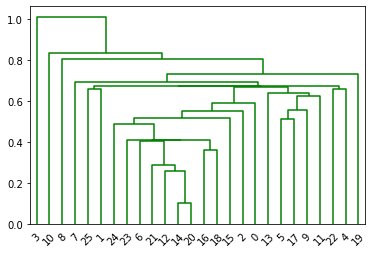

In [12]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z=linkage(study_matrix_norm,'single','correlation',optimal_ordering=True)
dendrogram(Z, color_threshold=1.035)
plt.show()

In [13]:
print("group 0 (NA) : ",narrative)
print("group 1 (SSA): ",stimulus)

group 0 (NA) :  [ 0  2  4  5  7  9 11 13 16 17 18 22 25]
group 1 (SSA):  [ 1  3  6  8 10 12 14 15 19 20 21 23 24]


### Hierarchical clustering based on euclidean distance

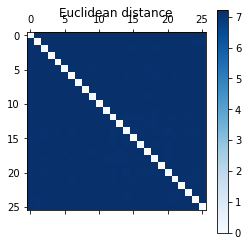

In [14]:
distance_matrix = computeDistanceMatrix(norm_coef,addCoef=add_coef)
plt.matshow(distance_matrix, cmap=plt.cm.Blues)
plt.title("Euclidean distance")
plt.colorbar()
plt.show()

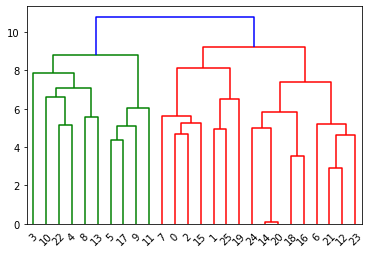

Found clusters 
[1 1 1 0 0 0 1 1 0 0 0 0 1 0 1 1 1 0 1 1 1 1 0 1 1 1]
True clusters 
[0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1 0]
Well classified
[ 1  4  5  6  9 11 12 13 14 15 17 19 20 21 22 23 24]
Wrong classified
[ 0  2  3  7  8 10 16 18 25]
Accuracy : 0.653846
Silhouette coefficient : 0.001


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [15]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

distance_matrix = computeDistanceMatrix(1.0002,addCoef=0,uncondensed=True,keepDiag=False) # Normalisations do not affect HC
Z=linkage(distance_matrix,'ward','euclidean',optimal_ordering=True)
threshold = 4-0.2*(case=='EEG') # 3.8 EEG, 4 EDA, 4 IBI if add_coef ==2
threshold = 1.5*(case!='EDA')+11.75*(case=='EDA') # 1.4 or 1.5 EEG, 4 EDA, 4 IBI if no normalisation
threshold = 7.3*(case=='EEG') # 7.3 EEG if keepDiag==True
threshold = 10
dendrogram(Z, color_threshold=threshold)
plt.show()

print("Found clusters ")
label = (fcluster(Z, t=threshold, criterion='distance')-1)
label_HC = label
print(label)
print("True clusters ")
print(condition)

subjects = np.arange(0,N)
wellClassified = subjects[label==condition]
misClassified = subjects[label!=condition]
SSA_HC = subjects[label==1] # Maybe NA
NA_HC = subjects[label==0] # Maybe SSA
print("Well classified")
print(wellClassified)
print("Wrong classified")
print(misClassified)
accuracy = len(wellClassified)/N
print("Accuracy : %f" %accuracy)
#[ 0  2  3  7  8 10 16 18 25]
distance_matrix = computeDistanceMatrix(norm_coef,addCoef=add_coef)
SC = silhouetteCoef(distance_matrix,label)
print("Silhouette coefficient : %0.3f" %SC)
if 'HC' not in methodUsed:
    accuracyVect = np.append(accuracyVect,accuracy)
    SCVect = np.append(SCVect,SC)
    methodUsed = np.append(methodUsed,'HC')
    prior = np.append(prior,'dist')

In [16]:
'''
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

distance_matrix = computeDistanceMatrix(norm_coef,addCoef=add_coef)
clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None,affinity="precomputed",linkage='single').fit(distance_matrix)
plot_dendrogram(clustering)

print("Found clusters ")
label = clustering.labels_
print(label)
print("True clusters ")
print(condition)

subjects = np.arange(0,N)
wellClassified = subjects[label==condition]
misClassified = subjects[label!=condition]
SSA_HC = subjects[label==1] # Maybe NA
NA_HC = subjects[label==0] # Maybe SSA
print("Well classified")
print(wellClassified)
print("Wrong classified")
print(misClassified)
accuracy = len(wellClassified)/N
print("Accuracy : %f" %accuracy)
#[ 0  2  3  7  8 10 16 18 25]
distance_matrix = computeDistanceMatrix(norm_coef,addCoef=add_coef)
SC = silhouetteCoef(distance_matrix,label)
print("Silhouette coefficient : %0.3f" %SC)
'''

'\nfrom sklearn.cluster import AgglomerativeClustering\n\ndef plot_dendrogram(model, **kwargs):\n    # Create linkage matrix and then plot the dendrogram\n\n    # create the counts of samples under each node\n    counts = np.zeros(model.children_.shape[0])\n    n_samples = len(model.labels_)\n    for i, merge in enumerate(model.children_):\n        current_count = 0\n        for child_idx in merge:\n            if child_idx < n_samples:\n                current_count += 1  # leaf node\n            else:\n                current_count += counts[child_idx - n_samples]\n        counts[i] = current_count\n\n    linkage_matrix = np.column_stack([model.children_, model.distances_,\n                                      counts]).astype(float)\n    \n    # Plot the corresponding dendrogram\n    dendrogram(linkage_matrix, **kwargs)\n\ndistance_matrix = computeDistanceMatrix(norm_coef,addCoef=add_coef)\nclustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None,affinity="precompu

## Affinity propagation

In [17]:
from sklearn.cluster import AffinityPropagation

af = AffinityPropagation(affinity="precomputed").fit(distance_matrix)
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
print('Estimated number of clusters: %d' % n_clusters_)

print("Found clusters ")
label = af.labels_
print(label)
print("True clusters ")
print(condition)

subjects = np.arange(0,N)
wellClassified = subjects[label==condition]
misClassified = subjects[label!=condition]
SSA_aff = subjects[label==1] # Maybe NA
NA_aff = subjects[label==0] # Maybe SSA
print("Well classified")
print(wellClassified)
print("Wrong classified")
print(misClassified)
accuracy = len(wellClassified)/N
print("Accuracy : %f" %accuracy)
n_clusters_ = len(cluster_centers_indices)
SC = silhouetteCoef(distance_matrix,label)
print("Silhouette coefficient : %0.3f" %SC)
if 'affinity' not in methodUsed:
    accuracyVect = np.append(accuracyVect,accuracy)
    SCVect = np.append(SCVect,SC)
    methodUsed = np.append(methodUsed,'affinity')
    prior = np.append(prior,'dist')

Estimated number of clusters: 2
Found clusters 
[0 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
True clusters 
[0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1 0]
Well classified
[ 0  2  5  6  8  9 10 11 13 16 17 18 19 22 25]
Wrong classified
[ 1  3  4  7 12 14 15 20 21 23 24]
Accuracy : 0.576923
Silhouette coefficient : 0.000


## K-Medoids 
robust with noisy data -> "Performance Analysis Of K-Means And K-Medoids Clustering Algorithms For A Randomly Generated Data Set"

In [18]:
from KMedoidsPaper import KMedoids
nRun = 10
random_init=True
# coefficients = np.linspace(1,45,2)
coefficients = [45] # Changing normalisation coefficient does not change mapping if add_coef large enough 
                    # (2 is ok for that and for only positive eigen values EEG)

kmedoids_result = DistanceMethodResults("k-medoids",random_init)
if (random_init): # Several runs with different random init
    kmedoids = KMedoids(n_clusters=2,tmax=1000)
    kmedoids_result.applyMethodAverage(kmedoids,coef=norm_coef,n_run=nRun,verbose=False) # 2D max I think, otherwise curse of dimensionnality
else: # one run with HC results for init
    kmedoids = KMedoids(n_clusters=2,tmax=1000,init=[NA_HC,SSA_HC]) # init array used before fit
    kmedoids_result.applyMethodAverage(kmedoids,coef=norm_coef) # 2D max I think, otherwise curse of dimensionnality
    
# Show results
kmedoids_result.twoClustersMethodResult()
if 'k-medoids' not in methodUsed:
    accuracyVect = np.append(accuracyVect,kmedoids_result.best_accuracy)
    SCVect = np.append(SCVect,kmedoids_result.SC)
    methodUsed = np.append(methodUsed,'k-medoids')
    prior = np.append(prior,'dist')
    
probaLabel = np.array([0.45, 0.72375, 0.3125, 0.73275, 0.32025, 0.29925, 0.7375, 0.4625, 0.5895, 0.40875, 0.56025, 0.38625, 0.5145, 0.34125, 0.585, 0.55275, 0.44675, 0.50525, 0.4885, 0.68875, 0.53775, 0.502, 0.3675, 0.5215, 0.63325, 0.6225])
print("norm : %f" %np.linalg.norm(probaLabel-kmedoids_result.probaLabel))
print("norm : %f" %np.linalg.norm(probaLabel-(1-kmedoids_result.probaLabel)))

Computing clustering

Results

Found clusters 
[1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1]
True clusters 
[0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1 0]
Well classified
[ 1  8 10 12 14 20 23 24]
Wrong classified
[ 0  2  3  4  5  6  7  9 11 13 15 16 17 18 19 21 22 25]
Best k-medoids accuracy : 0.692308
Silhouette coefficient : 0.000
Robust participants
[1 0 1 0 0 1 0 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 1 0]
[ 0  2  5  8  9 11 13 14 15 16 17 18 19 21 22 24]
Frequencies
[0.7 0.6 0.7 0.4 0.5 0.7 0.4 0.6 0.7 0.9 0.5 0.8 0.5 1.  0.8 0.2 0.9 0.9
 0.7 0.1 0.6 0.2 1.  0.6 0.7 0.5]
norm : 1.723651
norm : 1.221463


## Spectral clustering (precomputed -> distance matrix)

In [19]:
'''
from sklearn.cluster import SpectralClustering

distance_matrix = computeDistanceMatrix(norm_coef,addCoef=add_coef)
clustering = SpectralClustering(n_clusters=2, n_init=1000,affinity='precomputed').fit(distance_matrix)
print("Found clusters ")
label = clustering.labels_
print(label)
print("True clusters ")
print(condition)

subjects = np.arange(0,N)
wellClassified = subjects[label==condition]
misClassified = subjects[label!=condition]
SSA_SC = subjects[label==1] # Maybe NA
NA_SC = subjects[label==0] # Maybe SSA
print("Well classified")
print(wellClassified)
print("Wrong classified")
print(misClassified)
accuracy = len(wellClassified)/N
print("Accuracy : %f" %accuracy)
SC = silhouetteCoef(distance_matrix,label)
print("Silhouette coefficient : %0.3f" %SC)
if 'SC_dist' not in methodUsed:
    accuracyVect = np.append(accuracyVect,accuracy)
    SCVect = np.append(SCVect,SC)
    methodUsed = np.append(methodUsed,'SC_dist')
    prior = np.append(prior,'dist')
''' 
    
nRun= 10
    
from sklearn.cluster import SpectralClustering

# coefficients = np.linspace(1,45,2)
coefficients = [45] # Changing normalisation coefficient does not change mapping if add_coef large enough 
                    # (2 is ok for that and for only positive eigen values EEG)

clusteringDist_result = DistanceMethodResults("spectral clustering based on distances",random_init)
if (random_init): # Several runs with different random init
    clusteringDist = SpectralClustering(n_clusters=2, n_init=100,affinity='precomputed')
    clusteringDist_result.applyMethodAverage(clusteringDist,coef=norm_coef,n_run=nRun) # 2D max I think, otherwise curse of dimensionnality
    
    # Show results
    clusteringDist_result.twoClustersMethodResult()
    if 'SC_dist' not in methodUsed:
        accuracyVect = np.append(accuracyVect,clusteringDist_result.best_accuracy)
        SCVect = np.append(SCVect,clusteringDist_result.SC)
        methodUsed = np.append(methodUsed,'SC_dist')
        prior = np.append(prior,'dist')
        
        
print(len(clusteringDist_result.allLabel))


Computing clustering

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
Results

Found clusters 
[1 1 0 1 0 0 0 0 1 0 1 1 0 0 1 0 1 1 1 0 0 1 1 1 0 0]
True clusters 
[0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1 0]
Well classified
[ 1  2  3  4  5  7  8  9 10 13 14 21 23 25]
Wrong classified
[ 0  6 11 12 15 16 17 18 19 20 22 24]
Best spectral clustering based on distances accuracy : 0.538462
Silhouette coefficient : -0.000
Robust participants
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Frequencies
[1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1.
 0. 0.]
1


## Multi Dimensionnal Scaling

### Modified scikit MDS (because there is no normalised stress) (metric and non-metric)

In [20]:
from MDS_normalized import MDS as MDS_norm
from sklearn import preprocessing

# MDS with normalised stress, distance_matrix must be symmetric in scikit
def computeMDSCoordinate(distance_matrix,n_comp,metric=False,printStress=False,dissimilarity='precomputed',random_state=None,max_iter=300,n_init=4,init=None):
    mds = MDS_norm(n_components=n_comp,random_state=random_state,normalize=True,eps=1e-6,metric=metric,dissimilarity=dissimilarity,max_iter=max_iter,n_init=n_init,verbose=0)
    mds.fit(distance_matrix,init=init)
    points = mds.embedding_
    stress = mds.stress_
    disparities = mds.disparities_
    '''
    Stress-1 that according to Kruskal (1964, p. 3) has more or less 
    the following interpretation: value 0 indicates perfect fit, 
    0.025 excellent, 0.05 good, 0.1 fair and 0.2 poor.
    '''
    if (printStress):
        print("Stress of the method : %f" %stress)
    #points = preprocessing.scale(points,axis=1)
    return points, stress, disparities

//anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


### Scikit MDS (metric and non-metric)

In [21]:
# Scikit MDS
from sklearn.manifold import MDS

def mdsScikit(n_comp,distance_matrix,dissimilarity='precomputed',random_state=None,init=None,metric=False):
    mds = MDS(n_components=n_comp,random_state=random_state,dissimilarity=dissimilarity,eps=1e-10,metric=metric)
    mds.fit(distance_matrix,init=init)
    points = mds.embedding_
    stress = mds.stress_

    '''
    # Normalise data
    for i in range(n_comp):
        points[:,i] = (points[:,i] - np.mean(points[:,i])) / np.std(points[:,i])
    '''
    #points = preprocessing.scale(points,axis=1)
    return points

### MDS functions

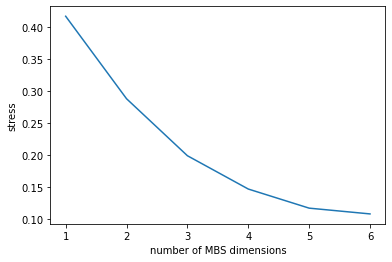

In [22]:
from sklearn.decomposition import PCA

# Make PCA to project MDS data in 2D
def transformPoints(points,n_comp=2):
    if ((points.shape[1] != 2) or (n_comp!=2)):
        # Normalise data
        for i in range(len(points[1,:])):
            points[:,i] = (points[:,i] - np.mean(points[:,i])) / np.std(points[:,i])

        pca = PCA(n_components=n_comp)
        points = pca.fit_transform(points)
        #print("%f variance explained when plotting" %sum(pca.explained_variance_ratio_[:n_comp]))
    return points

# Show MDS scaling
import matplotlib.patches as mpatches

def plotPoints(points,projection=False,title='Ground truth',subjects=subjects):
    NA = np.where(condition[subjects]==0)[0]
    SSA = np.where(condition[subjects]==1)[0]

    if (points.shape[1] != 1):
        ax = plt.axes([1.2,0,1.2,1.2])
        ax.set_aspect(aspect='equal')
        if (projection):
            points = transformPoints(points)

        for i in range(len(points)):
            ax.annotate(subjects[i],(points[i,0],points[i,1]),xytext=(points[i,0]+(np.max(points[:,0])-np.min(points[:,0]))/50,points[i,1]))

        plt.scatter(points[NA,0],points[NA,1],color='blue',s=145,label='NA')
        plt.scatter(points[SSA,0],points[SSA,1],color='red',s=145,label='SSA')
    else:
        plt.scatter(points[NA],np.zeros((len(NA),1)),marker='x',color='blue')
        plt.scatter(points[SSA],np.zeros((len(SSA),1)),marker='x',color='red')
        orderedSubjectPlot = np.argsort(points.T)
        for i in range(len(points)):
            subj = orderedSubjectPlot[0,i]
            plt.annotate(subj,(points[subj,0],0),xytext=(points[subj,0]-((i+1)%2+1)*np.max(points)/35,0.01*(i%2)-0.0065))
        
    NA = mpatches.Patch(color='blue', label='NA')
    SSA = mpatches.Patch(color='red', label='SSA')
    plt.legend(handles=[NA,SSA])
    
    plt.title(title)
    
# Shepard diagram
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import euclidean_distances

def shepardDiagram(distance_matrix,points,disparities,title=''):
    ax = plt.axes([0,0,1.2,1.2])
    #ax.set_aspect(aspect='equal')
    
    order = np.lexsort((np.ravel(distance_matrix),np.ravel(disparities)))

    computedDistances = pdist(points);
    computedDistances = squareform(computedDistances);
    computedDistances = euclidean_distances(points)

    plt.scatter(np.ravel(distance_matrix),np.ravel(computedDistances))
    plt.plot(np.ravel(distance_matrix)[order],np.ravel(disparities)[order],'r.')
    plt.xlabel('Dissimilarities')
    plt.ylabel('Distances/Disparities')
    plt.title(title)
    corr = np.corrcoef(np.ravel(computedDistances),np.ravel(disparities))
    return corr[1,0]

# Find best MDS dimension
stress = np.zeros((int(N/4),1)) # dimension rule : dimension < N/4 
distance_matrix = computeDistanceMatrix(norm_coef,addCoef=add_coef)
for i in range(1,int(N/4)+1):
    points,stress[i-1],disparities = computeMDSCoordinate(distance_matrix,i,random_state=1)

plt.plot(np.arange(1,int(N/4)+1),stress)
plt.xlabel("number of MBS dimensions")
plt.ylabel("stress")

# EEG : 6
# EDA : 3 or 4
mdsDim = 6


### mMDS results

In [23]:
def compareMDS(mds_dim,metric):
    if (metric):
        meth = 'Metric MDS'
    elif (metric==False):
        meth = 'Non metric MDS'
    
    plt.figure()
    distance_matrix = computeDistanceMatrix(1,addCoef=0,keepDiag=True)
    points,stress,disparities = computeMDSCoordinate(distance_matrix,mds_dim,random_state=1,printStress=True,metric=metric,max_iter=1000)
    corrCoef = shepardDiagram(distance_matrix,points,disparities,'%s shepard diagram' %meth)
    title = '%s original distance matrix' %meth
    print(title)
    print("Correlation coefficient %f" %corrCoef)
    plotPoints(points,projection=True,title=title)

    plt.figure()
    distance_matrix = computeDistanceMatrix(45,addCoef=0,keepDiag=False)
    points,stress,disparities = computeMDSCoordinate(distance_matrix,mds_dim,random_state=1,printStress=True,metric=metric,max_iter=1000)
    corrCoef = shepardDiagram(distance_matrix,points,disparities,'%s shepard diagram' %meth)
    title = '%s map (normCoef equivalent to keep diagonal)' %meth
    print(title)
    print("Correlation coefficient %f" %corrCoef)
    plotPoints(points,projection=True,title=title)
    
    plt.figure()
    distance_matrix = computeDistanceMatrix(1.2,addCoef=0,keepDiag=False)
    points,stress,disparities = computeMDSCoordinate(distance_matrix,mds_dim,random_state=1,printStress=True,metric=metric,max_iter=1000)
    corrCoef = shepardDiagram(distance_matrix,points,disparities,'%s shepard diagram' %meth)
    title = '%s map with normCoef to simulate higher correlations = lower distances' %meth
    print(title)
    print("Correlation coefficient %f" %corrCoef)
    plotPoints(points,projection=True,title=title)

    plt.figure()
    distance_matrix = computeDistanceMatrix(1,addCoef=4,keepDiag=True)
    points,stress,disparities = computeMDSCoordinate(distance_matrix,mds_dim,random_state=1,printStress=True,metric=metric,max_iter=1000)
    corrCoef = shepardDiagram(distance_matrix,points,disparities,'%s shepard diagram' %meth)
    title = '%s map with constant added to have positive eigenValues' %meth
    print(title)
    print("Correlation coefficient %f" %corrCoef)
    plotPoints(points,projection=True,title=title)

    plt.figure()
    distance_matrix = computeDistanceMatrix(1.2,addCoef=4,keepDiag=False)
    points,stress,disparities = computeMDSCoordinate(distance_matrix,mds_dim,random_state=1,printStress=True,metric=metric,max_iter=1000)
    corrCoef = shepardDiagram(distance_matrix,points,disparities,'%s shepard diagram' %meth)
    title = '%s map with constant added and higher correlations' %meth
    print(title)
    print("Correlation coefficient %f" %corrCoef)
    plotPoints(points,projection=True,title=title)

Stress of the method : 0.387492
Metric MDS original distance matrix
Correlation coefficient 0.423069
Stress of the method : 0.387488
Metric MDS map (normCoef equivalent to keep diagonal)
Correlation coefficient 0.423091
Stress of the method : 0.343339
Metric MDS map with normCoef to simulate higher correlations = lower distances
Correlation coefficient 0.622587
Stress of the method : 0.387883
Metric MDS map with constant added to have positive eigenValues
Correlation coefficient 0.422111
Stress of the method : 0.370529
Metric MDS map with constant added and higher correlations
Correlation coefficient 0.513722


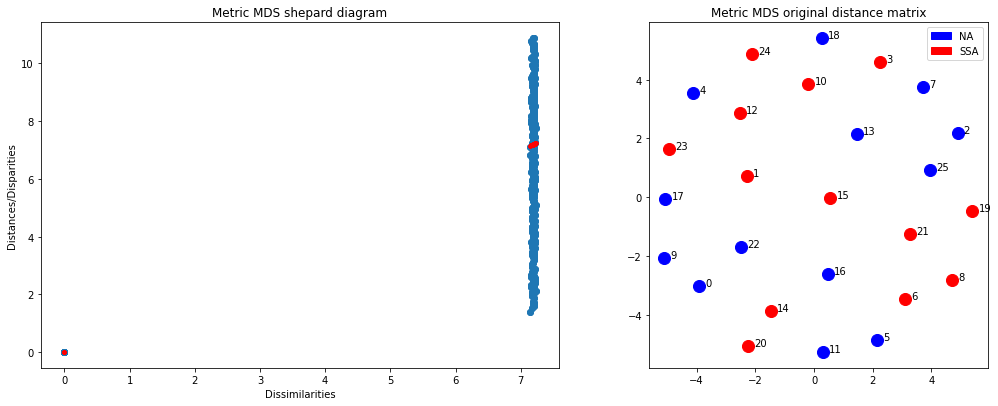

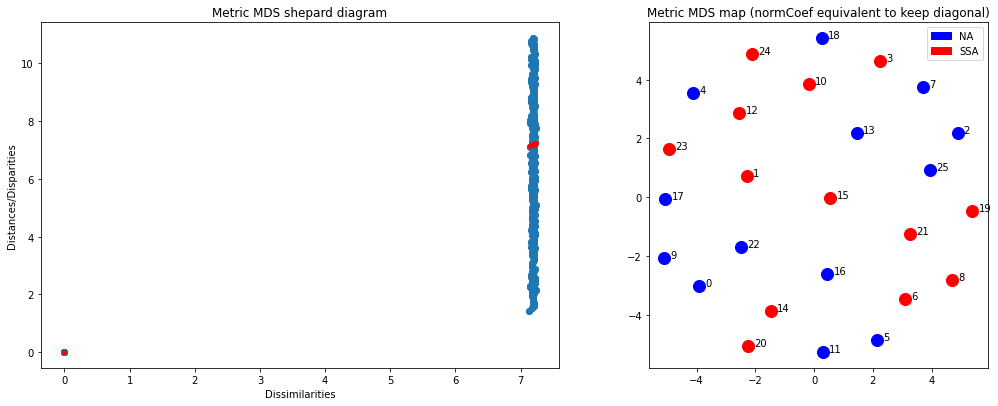

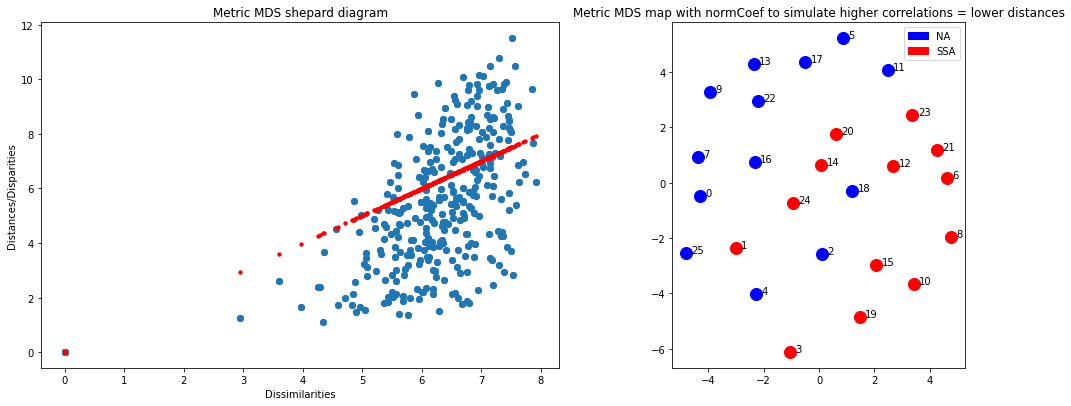

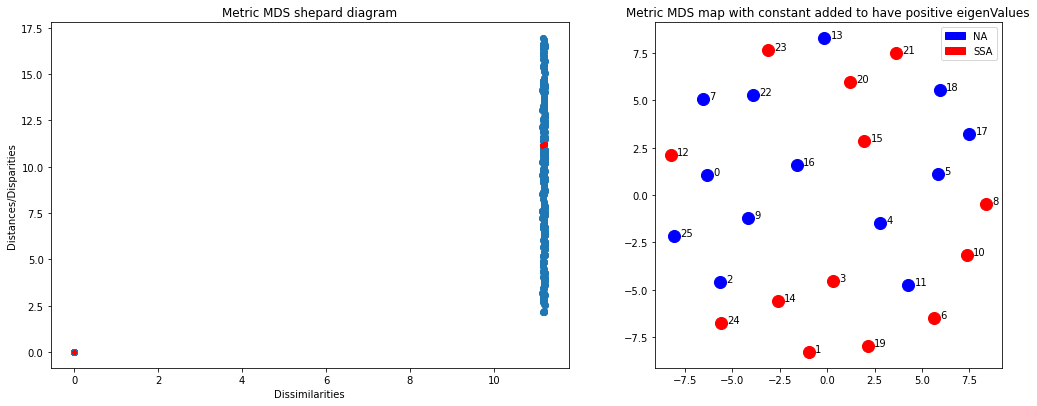

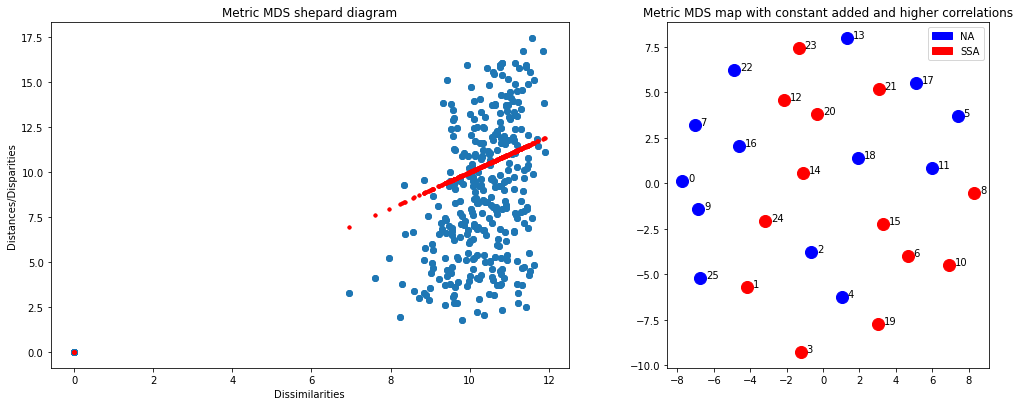

In [24]:
mdsDim = 2
compareMDS(mdsDim,metric=True)

### nMDS results

Stress of the method : 0.288062
Non metric MDS original distance matrix
Correlation coefficient 0.265098
Stress of the method : 0.288062
Non metric MDS map (normCoef equivalent to keep diagonal)
Correlation coefficient 0.265098
Stress of the method : 0.288062
Non metric MDS map with normCoef to simulate higher correlations = lower distances
Correlation coefficient 0.265098
Stress of the method : 0.288062
Non metric MDS map with constant added to have positive eigenValues
Correlation coefficient 0.265098
Stress of the method : 0.288062
Non metric MDS map with constant added and higher correlations
Correlation coefficient 0.265098


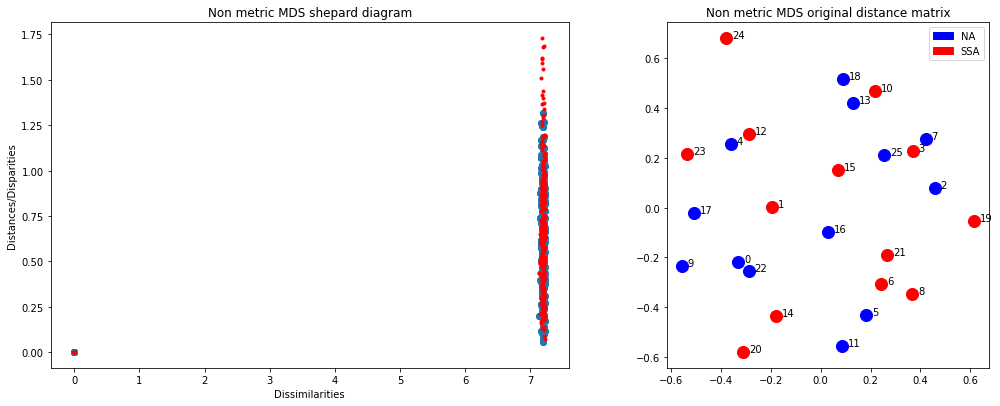

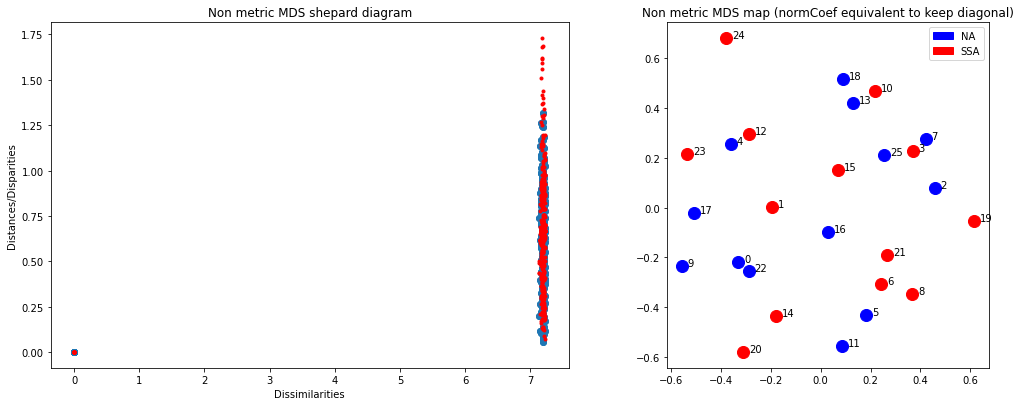

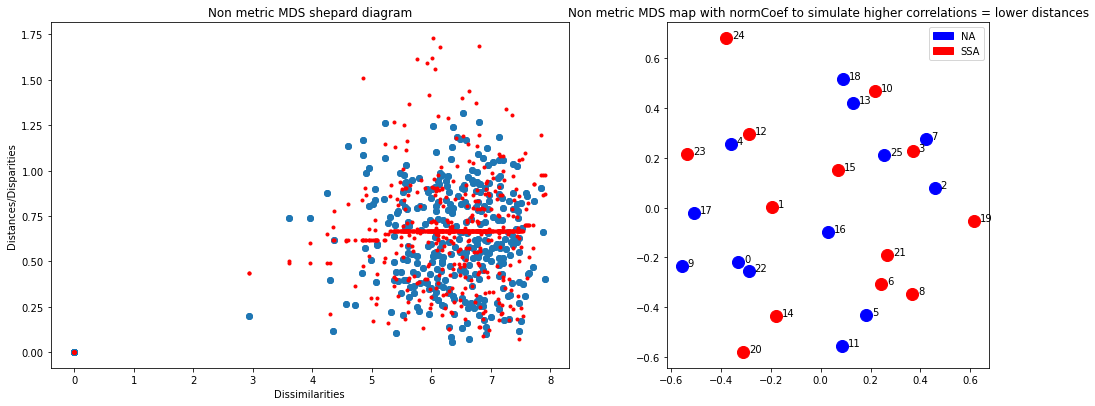

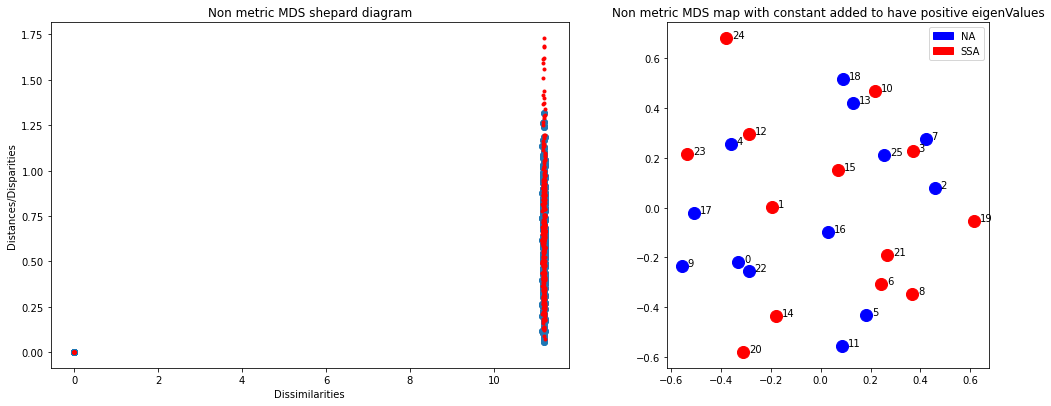

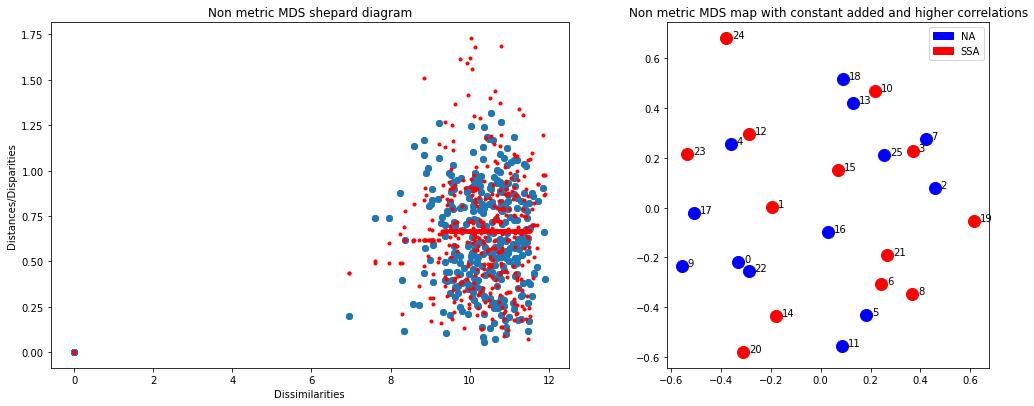

In [25]:
mdsDim = 2
compareMDS(mdsDim,metric=False)

In [26]:
try:
    plt.figure()
    distance_matrix = computeDistanceMatrix(1,addCoef=0,keepDiag=False)
    init = computePCoACoordinate(distance_matrix,n_comp=2)
    '''
    np.random.seed(2)
    init = np.zeros((N,2))
    init[:,0] = np.random.rand(N)
    init[:,1] = np.random.rand(N)
    '''
    points,stress,disparities = computeMDSCoordinate(distance_matrix,mdsDim,printStress=True,metric=True,max_iter=1000,n_init=1,init=init)
    shepardDiagram(distance_matrix,points,disparities,'Metric MDS shepard diagram')
    plotPoints(points,projection=True,title='Metric MDS map (PCoA init)')
except:
    print("run PCoA before")

run PCoA before


<Figure size 432x288 with 0 Axes>

In [27]:
try:
    plt.figure()
    distance_matrix = computeDistanceMatrix(norm_coef,addCoef=0,keepDiag=True)
    init = computePCoACoordinate(distance_matrix,n_comp=2)
    '''
    np.random.seed(2)
    init = np.zeros((N,2))
    init[:,0] = np.random.rand(N)
    init[:,1] = np.random.rand(N)
    '''
    points,stress,disparities = computeMDSCoordinate(distance_matrix,mdsDim,printStress=True,metric=False,max_iter=1000,n_init=1,init=init)
    shepardDiagram(distance_matrix,points,disparities,'Non metric MDS shepard diagram')
    plotPoints(points,projection=True,title='Non metric MDS map (PCoA init)')
except:
    print("run PCoA before")

run PCoA before


<Figure size 432x288 with 0 Axes>

run PCoA before


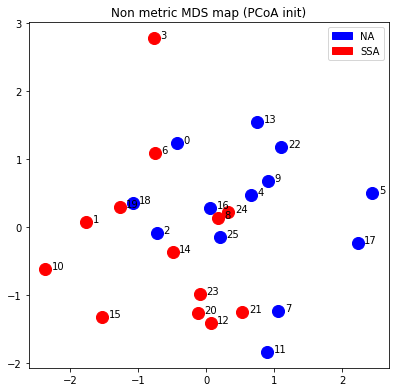

In [28]:
try:
    plotPoints(points,projection=True,title='Non metric MDS map (PCoA init)')
    points = mdsScikit(mdsDim,distance_matrix,dissimilarity='precomputed',random_state=None,init=init,metric=False)
except:
    print("run PCoA before")

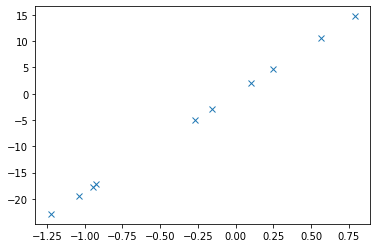

In [29]:
from sklearn.isotonic import IsotonicRegression

#distance_matrix = computeDistanceMatrix(1,addCoef=0)
#X = distance_matrix
#iso_reg = IsotonicRegression().fit(X.flatten(), y)

from sklearn.datasets import make_regression
from sklearn.isotonic import IsotonicRegression
X, y = make_regression(n_samples=10, n_features=1, random_state=41)
#y += np.random.rand(len(y))
#plt.plot(X,label='X')
#plt.plot(y,label='y')
#plt.legend()
plt.plot(X,y,'x')
iso_reg = IsotonicRegression().fit_transform(X.flatten(), y)
#plt.plot(X,iso_reg)

## Deterministic PCoA = classical MDS

[-646.4047476  -646.55269614 -645.60234107 -650.90233293 -647.70463544
 -647.85486516 -646.46145417 -646.38150261 -647.89184826 -647.06409949
 -647.62214372 -646.81592819 -645.26030718 -646.81823774 -643.5489286
 -646.56475235 -645.40911102 -646.25563142 -644.58845299 -648.18602069
 -645.12225571 -646.11253803 -646.6467305  -646.29676765 -645.49413665
 -648.30316809]
[-16165.20477087    -26.99232291    -26.64759697    -26.51904645
    -26.46289814    -26.2711903     -26.21254752    -26.19439367
    -26.0936757     -26.02331106    -25.97865294    -25.890459
    -25.89023596    -25.80308001    -25.76037601    -25.69287282
    -25.67039642    -25.62787233    -25.57799005    -25.53254879
    -25.49920805    -25.41919329    -25.29879839    -25.25670426
    -25.22258918    -25.12290231]


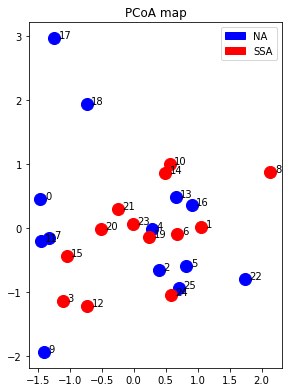

In [30]:
from skbio.stats.ordination import pcoa

def computePCoACoordinate(distance_matrix,n_comp=2):
    
    pcoa_map = pcoa(distance_matrix, method='eigh', number_of_dimensions=n_comp)
    #print(pcoa_map.proportion_explained)
    #print("pcoa proportion explained : %s " %np.sum(pcoa_map.proportion_explained))
    #print("eigen values")
    #print(pcoa_map.eigvals)
    points = np.array(pcoa_map.samples)

    #points = preprocessing.scale(points,axis=1)
    
    #points = transformPoints(distance_matrix)
    
    #plt.figure()
    #plt.plot(pcoa_map.proportion_explained)
    return points

distance_matrix = computeDistanceMatrix(norm_coef,addCoef=add_coef)
points = computePCoACoordinate(distance_matrix,25)
points = transformPoints(points)
plotPoints(points,title='PCoA map')

G = -0.5*np.dot(distance_matrix,distance_matrix)
print(np.diag(G))
values , vectors = np.linalg.eig(G)
print(np.sort(values))

## HC on 25D points with ward and euclidean distances
Gives exactly same as HC on distance matrix

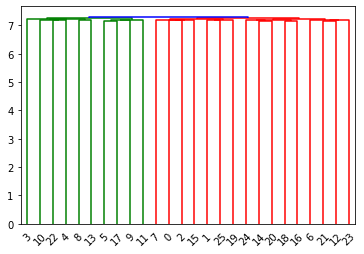

Found clusters 
[1 1 1 0 0 0 1 1 0 0 0 0 1 0 1 1 1 0 1 1 1 1 0 1 1 1]
True clusters 
[0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1 0]
Well classified
[ 1  4  5  6  9 11 12 13 14 15 17 19 20 21 22 23 24]
Wrong classified
[ 0  2  3  7  8 10 16 18 25]
Accuracy : 0.653846
Silhouette coefficient : 0.001


In [31]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster


distance_matrix = computeDistanceMatrix(1,addCoef=0,keepDiag=True) # Choose between 1 and 45, 
points = computePCoACoordinate(distance_matrix,25)
Z=linkage(points,'ward','euclidean',optimal_ordering=True)
threshold = 4-0.2*(case=='EEG') # 3.8 EEG, 4 EDA, 4 IBI if add_coef ==2
threshold = 1.5*(case!='EDA')+11.75*(case=='EDA') # 1.4 or 1.5 EEG, 4 EDA, 4 IBI if no normalisation
threshold = 7.3*(case=='EEG') # 7.3 EEG if keepDiag==True
#threshold = 10
dendrogram(Z, color_threshold=threshold)
plt.show()

print("Found clusters ")
label = (fcluster(Z, t=threshold, criterion='distance')-1)
label_HC = label
print(label)
print("True clusters ")
print(condition)

subjects = np.arange(0,N)
wellClassified = subjects[label==condition]
misClassified = subjects[label!=condition]
SSA_HC = subjects[label==1] # Maybe NA
NA_HC = subjects[label==0] # Maybe SSA
print("Well classified")
print(wellClassified)
print("Wrong classified")
print(misClassified)
accuracy = len(wellClassified)/N
print("Accuracy : %f" %accuracy)
#[ 0  2  3  7  8 10 16 18 25]
distance_matrix = computeDistanceMatrix(norm_coef,addCoef=add_coef)
SC = silhouetteCoef(distance_matrix,label)
print("Silhouette coefficient : %0.3f" %SC)
if 'HC' not in methodUsed:
    accuracyVect = np.append(accuracyVect,accuracy)
    SCVect = np.append(SCVect,SC)
    methodUsed = np.append(methodUsed,'HC')
    prior = np.append(prior,'dist')

## Weights for matlab MDS

In [32]:
from sklearn.metrics import pairwise_distances

distance_matrix = computeDistanceMatrix(norm_coef,addCoef=add_coef)
points = computePCoACoordinate(distance_matrix,2)
computedDist = pairwise_distances(points)

weights = (abs(computedDist-distance_matrix)/distance_matrix)
with open(os.path.join('weights_'+ case + '.csv'), 'w') as File:
    writer = csv.writer(File,delimiter =';')
    writer.writerows(weights)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


In [33]:
distance_matrix = computeDistanceMatrix(1,addCoef=0,keepDiag=True)
points = computePCoACoordinate(distance_matrix,N-1)
with open(os.path.join('dist_%s_coordinates.csv' %case), 'w') as File:
    writer = csv.writer(File,delimiter =';')
    writer.writerows(points)
#print(pairwise_distances(points))


## Multiview mapping

In [34]:
from multiview.mvmds import mvmds

def computeMVMDSCoordinate():

    distance_matrix_EEG = computeDistanceMatrix(1.1,addCoef=0,keepDiag=False,study_matrix=ISC_EEG)
    distance_matrix_EDA = computeDistanceMatrix(1.1,addCoef=0,keepDiag=False,study_matrix=ISC_EDA)
    distance_matrix_IBI = computeDistanceMatrix(1.1,addCoef=0,keepDiag=False,study_matrix=ISC_IBI)

    points = mvmds([distance_matrix_EEG,distance_matrix_EDA,distance_matrix_IBI],[True,True,True],2)
    #points = mvmds([distance_matrix_EEG,distance_matrix_EDA,distance_matrix_IBI],[False,False,False],2)
    return points

In [35]:
from sklearn.cluster import KMeans

nRun = 10
random_init = False
mds_random_init = False # MDS with several random init
nMDSRun = 50 # Number of mds runs with different random init if mds_random_init True
compute = True

if (compute):
    # coefficients = np.linspace(1,45,2)
    coefficients = [45] # Changing normalisation coefficient does not change mapping if add_coef large enough 
                        # (2 is ok for that and for only positive eigen values EEG)

    kmeans_result = MapMethodResults("k-means",random_init,n_neighbors = 4)
    if (random_init): # Make several runs
        if (mds_random_init): # MDS  
            kmeans = KMeans(n_clusters=2,n_init=1)
            kmeans_result.applyMethodAndMDSAverages(kmeans,dim=2,coef=norm_coef,n_run=nRun,n_mds_run=nMDSRun) # 2D max I think, otherwise curse of dimensionnality
        else:
            kmeans = KMeans(n_clusters=2,n_init=1)
            kmeans_result.applyMethodAverage(kmeans,dim=2,coef=norm_coef,n_run=nRun) # 2D max I think, otherwise curse of dimensionnality
    else: # Compare effect of normalization and dimension
        # kmeans = KMeans(n_clusters=2,n_init=1) # init array used before fit
        kmeans = KMeans(n_clusters=2,n_init=100)
        kmeans_result.applyMethod(kmeans,dim=[10]) # 2D max I think, otherwise curse of dimensionnality

Computing clustering

0%


Results

Best dimension 10 (7 means t-SNE)
Best normalisation 45 
Found clusters 
[0 1 1 1 0 0 1 1 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1 1]
True clusters 
[0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1 0]
Well classified
[ 0  1  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Wrong classified
[ 2  7 25]
Best k-means accuracy : 0.884615
Silhouette coefficient : 0.317
DB index : 1.148846 


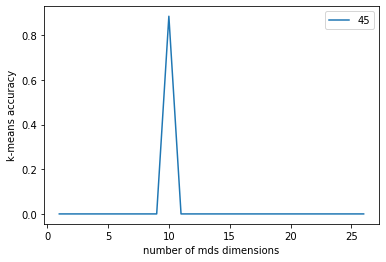

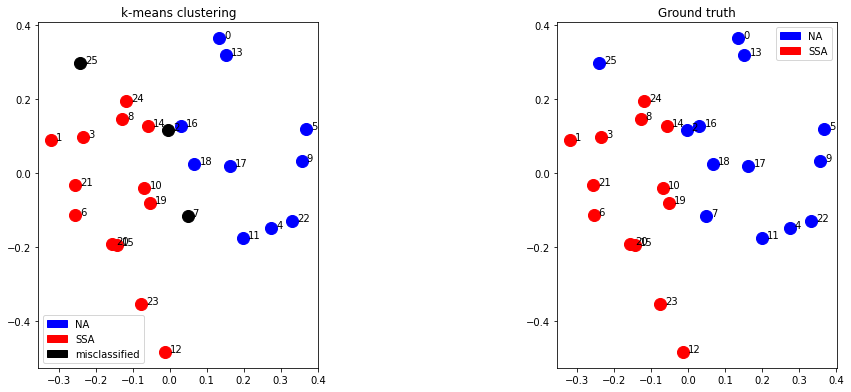

In [36]:
# Show results

if (compute):
    if (random_init==False):
        kmeans_result.clusteringAccuracyWithDimension()
    kmeans_result.twoClustersMethodResult()
    kmeans_result.showResultMap()
    plotPoints(kmeans_result.best_points)
    #plt.scatter(kmeans.init[:,0],kmeans.init[:,1],s=200,marker='x') # if t-SNE and 1 coef
    print("DB index : %f " %kmeans_result.dbScore())
    kmeans_result.writeProbaLabel()
    if 'k-means' not in methodUsed:
        accuracyVect = np.append(accuracyVect,kmeans_result.best_accuracy)
        SCVect = np.append(SCVect,kmeans_result.SC)
        methodUsed = np.append(methodUsed,'k-means')
        prior = np.append(prior,('t-SNE')*(kmeans_result.best_dim==7)+('PCoA '+str(abs(kmeans_result.best_dim)))*(kmeans_result.best_dim<0)+('MDS '+str(kmeans_result.best_dim))*(kmeans_result.best_dim<7)*(kmeans_result.best_dim>0))

In [37]:
import scipy.spatial.distance as ssd

def computeDistanceMatrix(normalisation=1,addCoef=0,uncondensed=False,euclideanTransform=True,finalNorm=False,rank=False,keepDiag=True,study_matrix=study_matrix): # Choose normalisation between 1 and 45, 
                                            # 45 means bigger non diagonal correlations almost 1
    matrix_norm = np.copy(study_matrix)
    if (keepDiag==False):
        for i in range(len(study_matrix)):
            matrix_norm[i,i] = 0
    maxi = np.max(abs(matrix_norm)) # Max value except from the diagonal

    for i in range(len(study_matrix)):
        matrix_norm[i,i] = maxi*normalisation

    # Normalise max value to 1
    matrix_norm = matrix_norm / np.max(abs(matrix_norm))

    # Convert into distance matrix
    if (euclideanTransform):
        distance_matrix = np.sqrt(1-matrix_norm)
        # distance_matrix = np.sqrt((1-matrix_norm)) # Formula in Matlab and in Scikit (?) to convert 
    else:
        distance_matrix = 1-matrix_norm
        
    # Check if bad construction
    for i in range(len(study_matrix)):
        if (distance_matrix[i,i]!=0):
            raise ValueError('Bad construction of distance matrix, not zero on diagonal')
            
    tmp_distance_matrix = np.copy(distance_matrix)
    
    for i in range(len(study_matrix)):
        tmp_distance_matrix[i,i]=1 # Change diagonal to be different from zero
    if (np.min(tmp_distance_matrix)==0):
        raise ValueError('Bad construction of distance matrix, zero outside diagonal')
        #print('Bad construction of distance matrix, zero outside diagonal')
    
    # Normalisation to avoid negative eigen values in PCoA
    distance_matrix = distance_matrix + addCoef
    for i in range(len(study_matrix)):
        distance_matrix[i,i] = 0
    
    # Transform matrix into uncondensed matrix
    if (uncondensed):
        distance_matrix = ssd.squareform(distance_matrix)
        
    # Transform matrix into rank matrix
    if (rank):
        rank_matrix = np.zeros_like(distance_matrix)
        for i in range(len(study_matrix)):
            rank_matrix[i,:] = rankify(distance_matrix[i,:])
        return rank_matrix
        
    ## Write new CSV file with all data
    if (uncondensed==False):
        with open(os.path.join('dist_'+ case + '.csv'), 'w') as File:
            writer = csv.writer(File,delimiter =';')
            writer.writerows(distance_matrix)
            
    if (finalNorm):
        distance_matrix = distance_matrix / np.std(distance_matrix) 

    return distance_matrix
    
'''
# Normalise data
for i in range(N):
    matrix[:,i] = (matrix[:,i] - np.mean(matrix[:,i])) / np.std(matrix[:,i])
'''

'\n# Normalise data\nfor i in range(N):\n    matrix[:,i] = (matrix[:,i] - np.mean(matrix[:,i])) / np.std(matrix[:,i])\n'

In [38]:
distance_matrix_basic = computeDistanceMatrix(1,addCoef=0,keepDiag=True,euclideanTransform=False)
distance_matrix_basic = computeDistanceMatrix(1.1,addCoef=0,keepDiag=False,euclideanTransform=False)
distance_matrix_normed = computeDistanceMatrix(22,addCoef=0,keepDiag=False,euclideanTransform=False)
print(distance_matrix_basic[:4,:4])
print(distance_matrix_normed[:4,:4])
print((1-distance_matrix_basic[:4,:4])/(1-distance_matrix_normed[:4,:4]))

[[0.         0.71152558 0.47737888 1.1629798 ]
 [0.71152558 0.         0.82103347 1.03643485]
 [0.47737888 0.82103347 0.         1.090439  ]
 [1.1629798  1.03643485 1.090439   0.        ]]
[[0.         0.98557628 0.97386894 1.00814899]
 [0.98557628 0.         0.99105167 1.00182174]
 [0.97386894 0.99105167 0.         1.00452195]
 [1.00814899 1.00182174 1.00452195 0.        ]]
[[ 1. 20. 20. 20.]
 [20.  1. 20. 20.]
 [20. 20.  1. 20.]
 [20. 20. 20.  1.]]


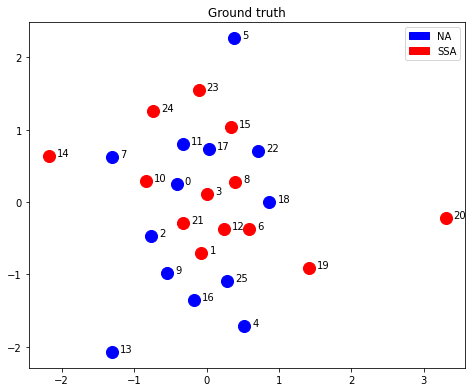

In [39]:
from multiview.mvtsne import MvtSNE
from sklearn.utils import check_random_state

distance_matrix_EEG = computeDistanceMatrix(1.1,addCoef=0,keepDiag=False,study_matrix=ISC_EEG)
distance_matrix_EDA = computeDistanceMatrix(1.1,addCoef=0,keepDiag=False,study_matrix=ISC_EDA)
distance_matrix_IBI = computeDistanceMatrix(1.1,addCoef=0,keepDiag=False,study_matrix=ISC_IBI)

mvtsne = MvtSNE(k=2,perplexity=3)
points = mvtsne.fit_transform([distance_matrix_EEG,distance_matrix_EDA,distance_matrix_IBI],[True,True,True])[0]
#points = mvtsne.fit_transform([distance_matrix_EEG,distance_matrix_EDA,distance_matrix_IBI],[False,False,False])
points = preprocessing.scale(points,axis=0)
plotPoints(points)

In [40]:
from multiview.mvsc import mvsc

def computeMVSCCoordinate():
    distance_matrix_EEG = computeDistanceMatrix(1.1,addCoef=1,keepDiag=False,study_matrix=ISC_EEG)
    distance_matrix_EDA = computeDistanceMatrix(1.1,addCoef=1,keepDiag=False,study_matrix=ISC_EDA)
    distance_matrix_IBI = computeDistanceMatrix(1.1,addCoef=1,keepDiag=False,study_matrix=ISC_IBI)

    MVSC = mvsc([distance_matrix_EEG,distance_matrix_EDA,distance_matrix_IBI],[True,True,True],2)
    points = MVSC[2]
    return points

0.9230769230769231
[ 2 25]


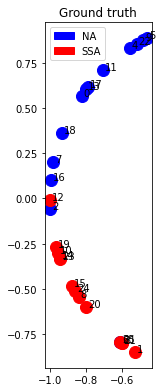

In [41]:
distance_matrix_EEG = computeDistanceMatrix(1.1,addCoef=0,keepDiag=False,study_matrix=ISC_EEG)
distance_matrix_EDA = computeDistanceMatrix(1.1,addCoef=0,keepDiag=False,study_matrix=ISC_EDA)
distance_matrix_IBI = computeDistanceMatrix(1.1,addCoef=0,keepDiag=False,study_matrix=ISC_IBI)

MVSC = mvsc([distance_matrix_EEG,distance_matrix_EDA,distance_matrix_IBI],[True,True,True],2)
points = MVSC[2]
#points = mvsc([distance_matrix_EEG,distance_matrix_EDA,distance_matrix_IBI],[False,False,False],2)
plotPoints(points)
label = MVSC[0]
acc = sum(condition==label)/N
if (acc<0.5):
    acc = 1-acc
    label = 1-label
print(acc)
misClassified = subjects[condition!=label]
print(misClassified)

In [42]:
from sklearn.cluster import KMeans

nRun = 10
random_init = False
mds_random_init = False # MDS with several random init
nMDSRun = 50 # Number of mds runs with different random init if mds_random_init True
compute = True

if (compute):
    # coefficients = np.linspace(1,45,2)
    coefficients = [45] # Changing normalisation coefficient does not change mapping if add_coef large enough 
                        # (2 is ok for that and for only positive eigen values EEG)

    kmeans_result = MapMethodResults("k-means",random_init,n_neighbors = 4)
    if (random_init): # Make several runs
        if (mds_random_init): # MDS  
            kmeans = KMeans(n_clusters=2,n_init=1)
            kmeans_result.applyMethodAndMDSAverages(kmeans,dim=2,coef=norm_coef,n_run=nRun,n_mds_run=nMDSRun) # 2D max I think, otherwise curse of dimensionnality
        else:
            kmeans = KMeans(n_clusters=2,n_init=1)
            kmeans_result.applyMethodAverage(kmeans,dim=2,coef=norm_coef,n_run=nRun) # 2D max I think, otherwise curse of dimensionnality
    else: # Compare effect of normalization and dimension
        # kmeans = KMeans(n_clusters=2,n_init=1) # init array used before fit
        kmeans = KMeans(n_clusters=2,n_init=100)
        kmeans_result.applyMethod(kmeans,dim=[0]) # 2D max I think, otherwise curse of dimensionnality

Computing clustering

0%


Results

Best dimension 0 (7 means t-SNE)
Best normalisation 45 
Found clusters 
[0 1 1 1 0 0 1 0 1 0 1 0 0 0 1 1 0 0 0 1 1 1 0 1 1 1]
True clusters 
[0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1 0]
Well classified
[ 0  1  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 22 23 24]
Wrong classified
[ 2 12 25]
Best k-means accuracy : 0.884615
Silhouette coefficient : 0.622
DB index : 0.520159 


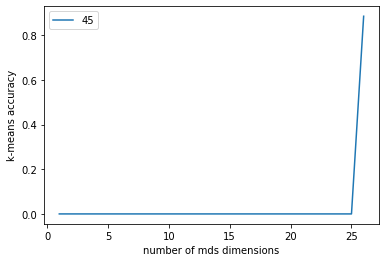

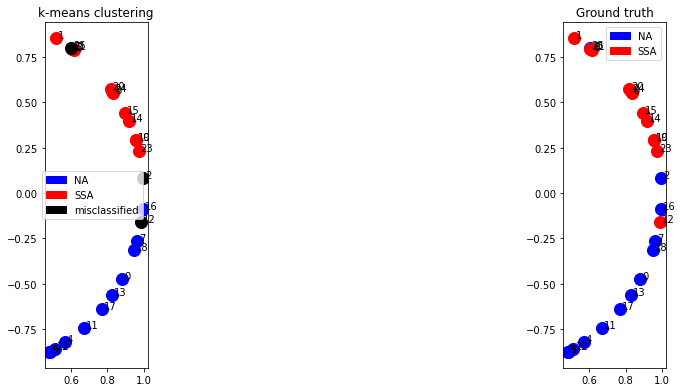

In [43]:
# Show results
if (compute):
    if (random_init==False):
        kmeans_result.clusteringAccuracyWithDimension()
    kmeans_result.twoClustersMethodResult()
    kmeans_result.showResultMap()
    plotPoints(kmeans_result.best_points)
    #plt.scatter(kmeans.init[:,0],kmeans.init[:,1],s=200,marker='x') # if t-SNE and 1 coef
    print("DB index : %f " %kmeans_result.dbScore())
    kmeans_result.writeProbaLabel()
    if 'k-means' not in methodUsed:
        accuracyVect = np.append(accuracyVect,kmeans_result.best_accuracy)
        SCVect = np.append(SCVect,kmeans_result.SC)
        methodUsed = np.append(methodUsed,'k-means')
        prior = np.append(prior,('t-SNE')*(kmeans_result.best_dim==7)+('PCoA '+str(abs(kmeans_result.best_dim)))*(kmeans_result.best_dim<0)+('MDS '+str(dim))*(kmeans_result.best_dim<7)*(kmeans_result.best_dim>0))

//anaconda3/lib/python3.7/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -18.080224852823257 and the largest is 42.692732184495114.
  RuntimeWarning
//anaconda3/lib/python3.7/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.185094303

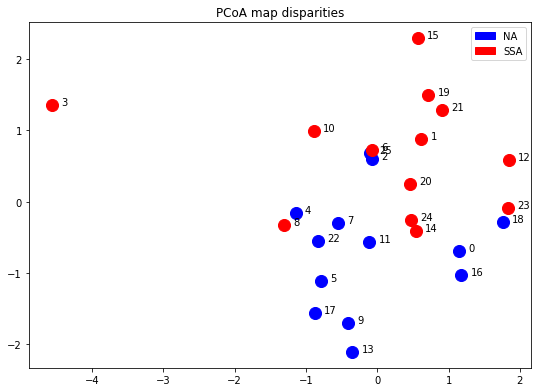

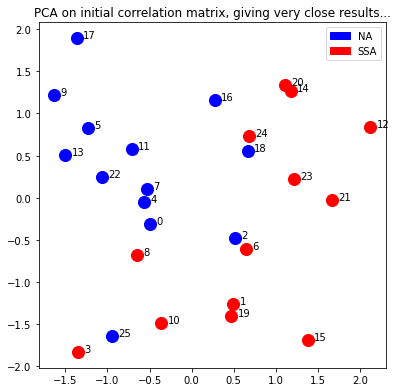

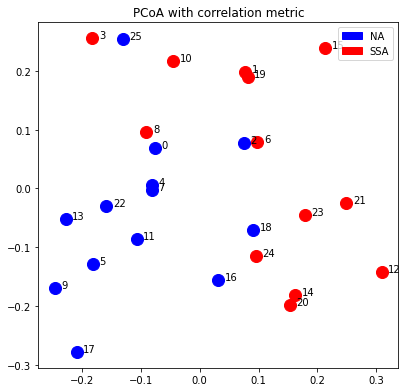

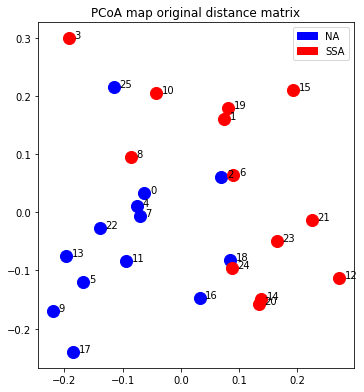

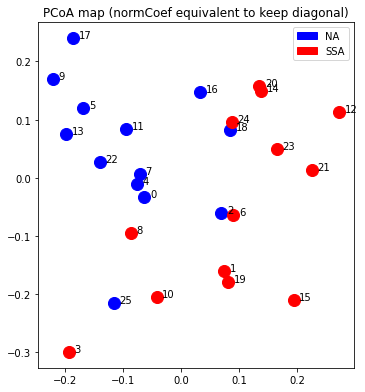

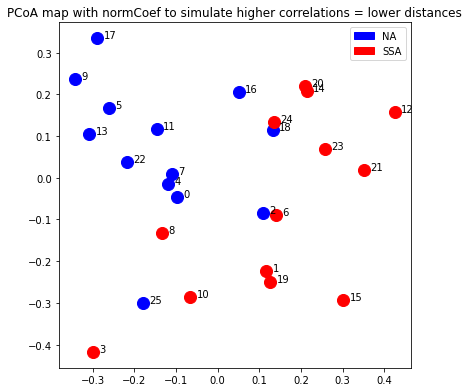

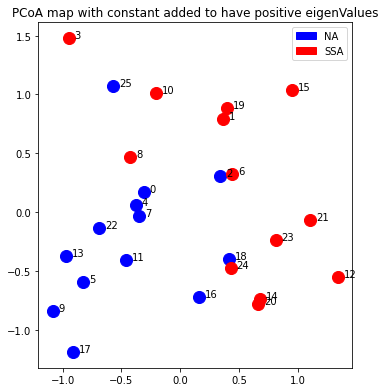

In [44]:
disparities = np.genfromtxt(os.path.join('disparities.csv'),delimiter=',')
disparities = np.array(disparities,dtype='float') # Convert into array

from sklearn.metrics import pairwise_distances

def comparePCoA():
    
    plt.figure()
    distance_matrix = disparities
    points = computePCoACoordinate(distance_matrix,2)
    points = transformPoints(points)
    plotPoints(points,title='PCoA map disparities')
    
    plt.figure()
    points = transformPoints(np.copy(study_matrix))
    #points = transformPoints(distance_matrix)
    plotPoints(points,title='PCA on initial correlation matrix, giving very close results...')
    
    plt.figure()
    distance_matrix = pairwise_distances(study_matrix,metric='correlation')
    points = computePCoACoordinate(distance_matrix,2)
    points = transformPoints(points)
    plotPoints(points,title='PCoA with correlation metric')
    
    plt.figure()
    distance_matrix = computeDistanceMatrix(1,addCoef=0,keepDiag=True)
    points = computePCoACoordinate(distance_matrix,2)
    points = transformPoints(points)
    plotPoints(points,title='PCoA map original distance matrix')

    plt.figure()
    distance_matrix = computeDistanceMatrix(45,addCoef=0,keepDiag=False)
    points = computePCoACoordinate(distance_matrix,2)
    points = transformPoints(points)
    plotPoints(points,title='PCoA map (normCoef equivalent to keep diagonal)')
    
    plt.figure()
    distance_matrix = computeDistanceMatrix(1.2,addCoef=0,keepDiag=False)
    points = computePCoACoordinate(distance_matrix,2)
    points = transformPoints(points)
    plotPoints(points,title='PCoA map with normCoef to simulate higher correlations = lower distances')
    
    plt.figure()
    distance_matrix = computeDistanceMatrix(45,addCoef=4,keepDiag=False)
    points = computePCoACoordinate(distance_matrix,2)
    points = transformPoints(points)
    plotPoints(points,title='PCoA map with constant added to have positive eigenValues')
    
comparePCoA()

### PCoA gradually adding participants

[24  8 20 13 17 15  0 14 11 10 19 18  3  6 21  4 25 23  7 22  5  9  1 12
  2 16]


//anaconda3/lib/python3.7/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.18509430357757797 and the largest is 1.2606717862993144.
  RuntimeWarning


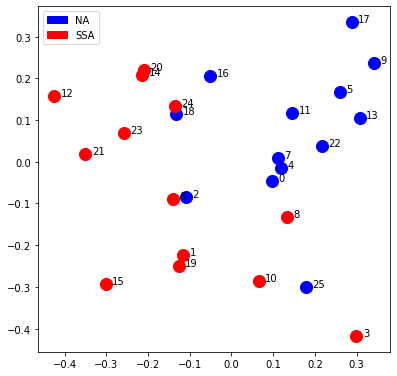

In [45]:
def kargmin(array, k):
    tmp = np.copy(array)
    tmp = np.argsort(tmp)
    return tmp[:k]

def bestClassifiedOverAll(result,k):
    foundNA = subjects[result.label==0]
    cluster0 = result.best_points[result.label==0]
    center0 = np.mean(cluster0,axis=0)
    foundSSA = subjects[result.label==1]
    cluster1 = result.best_points[result.label==1]
    center1 = np.mean(cluster1,axis=0)
    
    distArray0 = pairwise_distances(cluster0,np.tile(center0,(cluster0.shape[0],1)))[:,0]
    distArray1 = pairwise_distances(cluster1,np.tile(center1,(cluster1.shape[0],1)))[:,0]
    
    dist = np.concatenate((distArray0,distArray1))
    idx = np.argsort(np.concatenate((foundNA,foundSSA)))
    return kargmin(dist[idx],k)

sortedIdx = bestClassifiedOverAll(kmeans_result,N)
print(sortedIdx)
mat = np.copy(study_matrix[sortedIdx,:])
mat = mat[:,sortedIdx]


p = 26
mat = mat[:p,:p]

distance_matrix = computeDistanceMatrix(1.2,addCoef=0,keepDiag=False,study_matrix=mat)
points = computePCoACoordinate(distance_matrix,2)
points = transformPoints(points)
plotPoints(points,title='',subjects=sortedIdx)


### Comparing PCoA and PCA on distance matrix
Giving close results for our matrices, but not in general

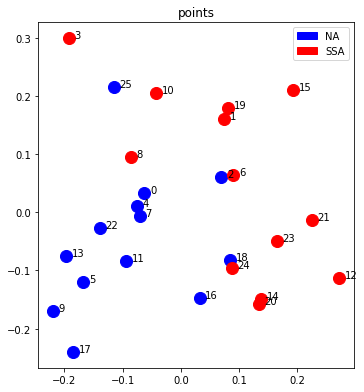

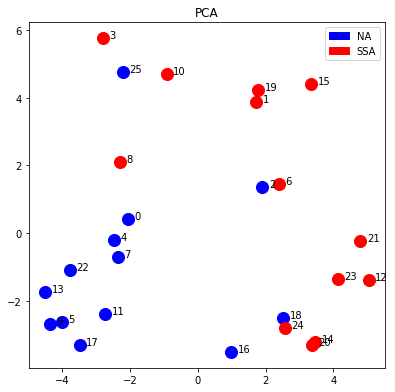

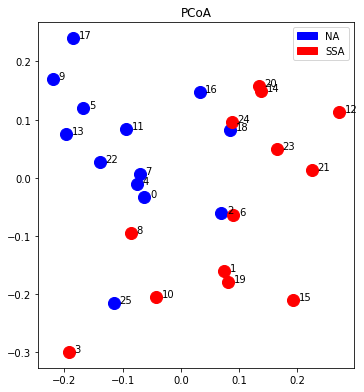

In [46]:
#study_matrix = ISC_EDA
distance_matrix = computeDistanceMatrix(1,addCoef=0,keepDiag=True)
pts = computePCoACoordinate(distance_matrix,2)
#dist = 1-np.eye(N)
#points = computePCoACoordinate(dist,2)
'''
np.random.seed(2)
pts = np.random.rand(N,2)
dist = euclidean_distances(pts)
dist = (dist+dist.T)/2
for i in range(N):
    dist[i,i] = 0
points = computePCoACoordinate(dist,2)
'''
plotPoints(pts,title='points')

dist = euclidean_distances(pts)
dist = (dist+dist.T)/2
#print(dist-dist.T)
newPoints = transformPoints(dist,2)
plt.figure()
plotPoints(newPoints,title='PCA')

dist = euclidean_distances(pts)
dist = (dist+dist.T)/2

newPoints = computePCoACoordinate(dist,2)
plt.figure()
plotPoints(newPoints,title='PCoA')

## t-SNE

//anaconda3/lib/python3.7/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.32129187242067303 and the largest is 1.4118942493098692.
  RuntimeWarning


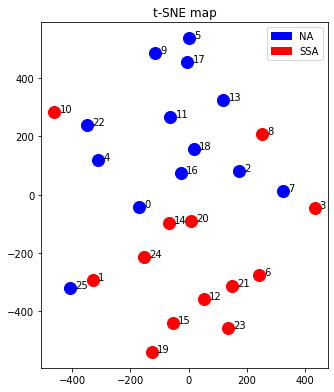

In [47]:
from sklearn.manifold import TSNE

def computeSNECoordinate(distance_matrix,n_pcoa_comp=2,n_tsne_comp=2):
    #points,stress,disparities = computeMDSCoordinate(distance_matrix,mdsDim,dissimilarity='precomputed',printStress=True)
    pcoa_points = computePCoACoordinate(distance_matrix,n_pcoa_comp)
    points_lessD = transformPoints(pcoa_points,n_tsne_comp)
    tsne = TSNE(n_components=n_tsne_comp, perplexity=4, n_iter=3000,metric="precomputed", init=points_lessD)
    #tsne = TSNE(n_components=n_tsne_comp, perplexity=3, n_iter=3000,metric="correlation")
    tsne_points = tsne.fit_transform(distance_matrix)
    #tsne_points = transformPoints(tsne_points)
    #tsne_points = preprocessing.scale(tsne_points,axis=1)
    return tsne_points
    
distance_matrix = computeDistanceMatrix(1.001,addCoef=add_coef,keepDiag=False)
points = computeSNECoordinate(distance_matrix)
plotPoints(points,title='t-SNE map')

## LDA

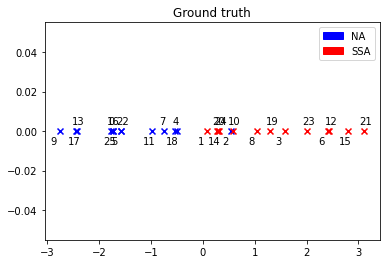

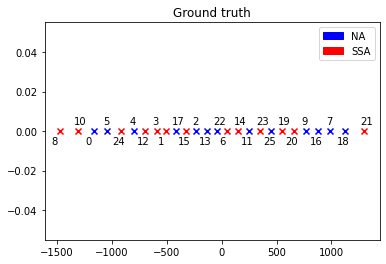

In [48]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

dim = 5
distance_matrix = computeDistanceMatrix(norm_coef,addCoef=add_coef)
points = computePCoACoordinate(distance_matrix,dim)
lda = LinearDiscriminantAnalysis(n_components=1)
points = lda.fit(points, condition).transform(points)
plotPoints(points,'LDA map (not to cluster, just to see data)')

plt.figure()
distance_matrix = computeDistanceMatrix(norm_coef,addCoef=add_coef)
points = computeSNECoordinate(distance_matrix,dim,1)
plotPoints(points,'t-SNE 1D')

## Semi-supervised dimensionnality reduction

### Ivis

In [49]:
'''
from ivis import Ivis

distance_matrix = computeDistanceMatrix(norm_coef,addCoef=add_coef)
points,stress,disparities = computeMDSCoordinate(distance_matrix,mdsDim,dissimilarity='precomputed',printStress=True,random_state=1)

# -1 for unlabeled data
try:
    sslLabel = (kmeans_result.robustLabel)*(kmeans_result.label)-1*(kmeans_result.robustLabel==0)
except:
    sslLabel = (kmedoids_result.robustLabel)*(kmedoids_result.label)-1*(kmedoids_result.robustLabel==0)

model = Ivis(embedding_dims=2,k=4,batch_size=7,epochs=30)
pointsIvis = model.fit_transform(points, sslLabel)
'''

"\nfrom ivis import Ivis\n\ndistance_matrix = computeDistanceMatrix(norm_coef,addCoef=add_coef)\npoints,stress,disparities = computeMDSCoordinate(distance_matrix,mdsDim,dissimilarity='precomputed',printStress=True,random_state=1)\n\n# -1 for unlabeled data\ntry:\n    sslLabel = (kmeans_result.robustLabel)*(kmeans_result.label)-1*(kmeans_result.robustLabel==0)\nexcept:\n    sslLabel = (kmedoids_result.robustLabel)*(kmedoids_result.label)-1*(kmedoids_result.robustLabel==0)\n\nmodel = Ivis(embedding_dims=2,k=4,batch_size=7,epochs=30)\npointsIvis = model.fit_transform(points, sslLabel)\n"

In [50]:
'''
## MDS

plotPoints(points,title='MDS map')

ax = plt.axes([0,0,1.2,1.2])
ax.set_aspect(aspect='equal')

for i in range(N):
    ax.annotate(i,(points[i,0],points[i,1]),xytext=(points[i,0]+(np.max(points[:,0])-np.min(points[:,0]))/50,points[i,1]))

plt.scatter(points[sslLabel==0,0],points[sslLabel==0,1],color='blue',s=145,label='NA')
plt.scatter(points[sslLabel==1,0],points[sslLabel==1,1],color='red',s=145,label='SSA')
plt.scatter(points[sslLabel==-1,0],points[sslLabel==-1,1],color='black',s=145,label='unlabeled')

NA = mpatches.Patch(color='blue', label='labeled NA')
SSA = mpatches.Patch(color='red', label='labeled SSA')
unlabeled = mpatches.Patch(color='black', label='unlabeled')

plt.legend(handles=[NA,SSA,unlabeled])
plt.title('MDS map')

## Compare to Ivis

plt.figure()
plotPoints(pointsIvis,title='Ivis map')

ax = plt.axes([0,0,1.2,1.2])
ax.set_aspect(aspect='equal')

for i in range(N):
    ax.annotate(i,(pointsIvis[i,0],pointsIvis[i,1]),xytext=(pointsIvis[i,0]+np.max(pointsIvis)/20,pointsIvis[i,1]))

plt.scatter(pointsIvis[sslLabel==0,0],pointsIvis[sslLabel==0,1],color='blue',s=145,label='NA')
plt.scatter(pointsIvis[sslLabel==1,0],pointsIvis[sslLabel==1,1],color='red',s=145,label='SSA')
plt.scatter(pointsIvis[sslLabel==-1,0],pointsIvis[sslLabel==-1,1],color='black',s=145,label='unlabeled')

NA = mpatches.Patch(color='blue', label='labeled NA')
SSA = mpatches.Patch(color='red', label='labeled SSA')
unlabeled = mpatches.Patch(color='black', label='unlabeled')

plt.legend(handles=[NA,SSA,unlabeled])
plt.title('Ivis map')
'''

"\n## MDS\n\nplotPoints(points,title='MDS map')\n\nax = plt.axes([0,0,1.2,1.2])\nax.set_aspect(aspect='equal')\n\nfor i in range(N):\n    ax.annotate(i,(points[i,0],points[i,1]),xytext=(points[i,0]+(np.max(points[:,0])-np.min(points[:,0]))/50,points[i,1]))\n\nplt.scatter(points[sslLabel==0,0],points[sslLabel==0,1],color='blue',s=145,label='NA')\nplt.scatter(points[sslLabel==1,0],points[sslLabel==1,1],color='red',s=145,label='SSA')\nplt.scatter(points[sslLabel==-1,0],points[sslLabel==-1,1],color='black',s=145,label='unlabeled')\n\nNA = mpatches.Patch(color='blue', label='labeled NA')\nSSA = mpatches.Patch(color='red', label='labeled SSA')\nunlabeled = mpatches.Patch(color='black', label='unlabeled')\n\nplt.legend(handles=[NA,SSA,unlabeled])\nplt.title('MDS map')\n\n## Compare to Ivis\n\nplt.figure()\nplotPoints(pointsIvis,title='Ivis map')\n\nax = plt.axes([0,0,1.2,1.2])\nax.set_aspect(aspect='equal')\n\nfor i in range(N):\n    ax.annotate(i,(pointsIvis[i,0],pointsIvis[i,1]),xytext=(poi

In [51]:
distance_matrix = computeDistanceMatrix(norm_coef,addCoef=add_coef)


### UMAP

None


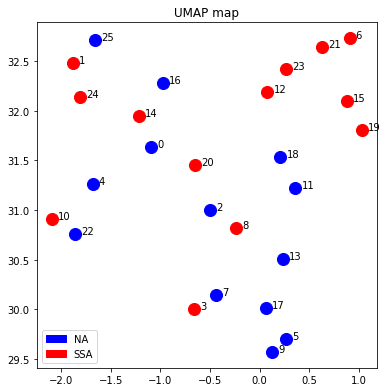

In [52]:
#import sys
#!{sys.executable} -m pip install umap-learn==0.3.10
import umap.umap_ as umap
from sklearn.metrics import pairwise_distances

def computeUMAPCoordinate(distance_matrix,sslLabel=None,n_pcoa_comp=2,n_neighbors=3):
    #points = computePCoACoordinate(distance_matrix,2)
    #a = np.arange(0,N,2)
    #sslLabel = -1*np.ones(N)
    #sslLabel[a] = condition[a]
    target_weight = 0.5
    #np.random.seed(42)
    #fitter = umap.UMAP(n_neighbors=3,metric='precomputed',min_dist=0.0,init='spectral',target_weight=target_weight,n_epochs=500).fit(distance_matrix)
    #study_matrix = ISC_EEG
    #for i in range(len(study_matrix)):
    #    study_matrix[i,i] = 300000
    #fitter = umap.UMAP(n_neighbors=3,metric='euclidean',min_dist=0.0,init='random',target_weight=target_weight,n_epochs=5000).fit(distance_matrix)


    #fitter = umap.UMAP(n_neighbors=n_neighbors,metric='correlation',min_dist=0.0,init='spectral',target_weight=target_weight,n_epochs=5000).fit(study_matrix,sslLabel)
    fitter = umap.UMAP(n_neighbors=n_neighbors,metric='precomputed',min_dist=0.0,init='spectral',target_weight=target_weight,n_epochs=5000).fit(distance_matrix,sslLabel)
    
    
    #fitter = umap.UMAP(n_neighbors=3,metric='correlation',min_dist=0.0,init='spectral',target_weight=target_weight,n_epochs=5000).fit(study_matrix)
    embedding = fitter.embedding_
    #embedding = transformPoints(embedding)
    #embedding = preprocessing.scale(embedding,axis=0)
    #print(target_weight)
    return embedding

removeOutlier = False
if (case == 'EEG'):
    if (removeOutlier): # Remove outliers if there are some
        ISC_EEG = removeOutlierArray(ISC_EEG,1) # Really outlier?
        ISC_EEG = removeOutlierArray(ISC_EEG,5-1) # Really outlier?       
        ISC_EEG = removeOutlierArray(ISC_EEG,9-2) # Really outlier?
        ISC_EEG = removeOutlierArray(ISC_EEG,10-3) # Really outlier?
        ISC_EEG = removeOutlierArray(ISC_EEG,17-4) # Really outlier?
        ISC_EEG = removeOutlierArray(ISC_EEG,22-5) # Really outlier?
        ISC_EEG = removeOutlierArray(ISC_EEG,25-6) # Really outlier?
        
        conditionLessPoints = removeOutlierVector(conditionLessPoints,1) # Really outlier?
        conditionLessPoints = removeOutlierVector(conditionLessPoints,5-1) # Really outlier?       
        conditionLessPoints = removeOutlierVector(conditionLessPoints,9-2) # Really outlier?
        conditionLessPoints = removeOutlierVector(conditionLessPoints,10-3) # Really outlier?
        conditionLessPoints = removeOutlierVector(conditionLessPoints,17-4) # Really outlier?
        conditionLessPoints = removeOutlierVector(conditionLessPoints,22-5) # Really outlier?
        conditionLessPoints = removeOutlierVector(conditionLessPoints,25-6) # Really outlier?
    study_matrix = ISC_EEG
    N = len(study_matrix)
    
'''
for i in range(len(study_matrix)):
    study_matrix[i,i] = np.mean(study_matrix)*100000
distance_matrix = computeDistanceMatrix(1,addCoef=0,keepDiag=True)
#distance_matrix = pairwise_distances(distance_matrix,metric="cosine")
distance_matrix = pairwise_distances(study_matrix,metric="correlation")
study = (1 - distance_matrix)*(np.max(study_matrix)/2)
for i in range(len(study)):
    study[i,i] = 3
distance_matrix = computeDistanceMatrix(1,addCoef=0,keepDiag=True,study_matrix=study)
print(distance_matrix)
'''
#for i in range(len(study_matrix)):
#    study_matrix[i,i] = 3
distance_matrix = computeDistanceMatrix(1,addCoef=0,keepDiag=True)
#print(pairwise_distances(study_matrix,metric="correlation")
#print(distance_matrix)
#distance_matrix = np.random.rand(N,N)
#distance_matrix = disparities

# -1 for unlabeled data
try:
    sslLabel = (kmeans_result.robustLabel)*(kmeans_result.label)-1*(kmeans_result.robustLabel==0)
except:
    sslLabel = (kmedoids_result.robustLabel)*(kmedoids_result.label)-1*(kmedoids_result.robustLabel==0)

a = np.arange(0,N,1)
sslLabel = -1*np.ones(N)
sslLabel[a] = condition[a]
sslLabel = None
#sslLabel = (subjects>N/2)
#sslLabel = condition
#sslLabel = np.arange(0,N)

#sslLabel[0] = 1-sslLabel[0]
#sslLabel[0] = -1
#sslLabel = kmeansSSL_result.sslLabel
print(sslLabel)

points = computeUMAPCoordinate(distance_matrix,sslLabel,n_neighbors=3)

plotPoints(points,title='UMAP map')

removeOutlierPointsBool = False

if (sslLabel is not None):
    if (removeOutlierPointsBool):
        if (case == 'EEG'):
            points = removeOutlierPoints(points,1) # Really outlier?
            points = removeOutlierPoints(points,5-1) # Really outlier?       
            points = removeOutlierPoints(points,9-2) # Really outlier?
            points = removeOutlierPoints(points,10-3) # Really outlier?
            points = removeOutlierPoints(points,17-4) # Really outlier?
            points = removeOutlierPoints(points,22-5) # Really outlier?
            points = removeOutlierPoints(points,25-6) # Really outlier?

            conditionLessPoints = removeOutlierVector(conditionLessPoints,1) # Really outlier?
            conditionLessPoints = removeOutlierVector(conditionLessPoints,5-1) # Really outlier?       
            conditionLessPoints = removeOutlierVector(conditionLessPoints,9-2) # Really outlier?
            conditionLessPoints = removeOutlierVector(conditionLessPoints,10-3) # Really outlier?
            conditionLessPoints = removeOutlierVector(conditionLessPoints,17-4) # Really outlier?
            conditionLessPoints = removeOutlierVector(conditionLessPoints,22-5) # Really outlier?
            conditionLessPoints = removeOutlierVector(conditionLessPoints,25-6) # Really outlier?
            N = len(conditionLessPoints)
            narrativeLessPoints = np.where(conditionLessPoints == 0)[0]
            stimulusLessPoints = np.where(conditionLessPoints == 1)[0]
            sslLabel = -1*np.ones(N)

        if (points.shape[1] != 1):
            ax = plt.axes([0,0,1.2,1.2])
            ax.set_aspect(aspect='equal')

            for i in range(len(points)):
                ax.annotate(i,(points[i,0],points[i,1]),xytext=(points[i,0]+(np.max(points[:,0])-np.min(points[:,0]))/50,points[i,1]))

            plt.scatter(points[narrativeLessPoints,0],points[narrativeLessPoints,1],color='blue',s=145,label='NA')
            plt.scatter(points[stimulusLessPoints,0],points[stimulusLessPoints,1],color='red',s=145,label='SSA')

    else:
        ax = plt.axes([0,0,1.2,1.2])
        ax.set_aspect(aspect='equal')

        for i in range(N):
            ax.annotate(i,(points[i,0],points[i,1]),xytext=(points[i,0]+(np.max(points[:,0])-np.min(points[:,0]))/50,points[i,1]))
        print(points[:,0])

        plt.scatter(points[sslLabel==0,0],points[sslLabel==0,1],color='blue',s=145,label='NA')
        plt.scatter(points[sslLabel==1,0],points[sslLabel==1,1],color='red',s=145,label='SSA')
        plt.scatter(points[sslLabel==-1,0],points[sslLabel==-1,1],color='black',s=145,label='unlabeled')

        NA = mpatches.Patch(color='blue', label='labeled NA')
        SSA = mpatches.Patch(color='red', label='labeled SSA')
        unlabeled = mpatches.Patch(color='black', label='unlabeled')

        plt.legend(handles=[NA,SSA,unlabeled])
        plt.title('UMAP map')

    '''
    ## Compare to MDS

    plotPoints(points,title='MDS map')

    ax = plt.axes([0,0,1.2,1.2])
    ax.set_aspect(aspect='equal')

    for i in range(N):
        ax.annotate(i,(points[i,0],points[i,1]),xytext=(points[i,0]+np.max(points)/20,points[i,1]))

    plt.scatter(points[sslLabel==0,0],points[sslLabel==0,1],color='blue',s=145,label='NA')
    plt.scatter(points[sslLabel==1,0],points[sslLabel==1,1],color='red',s=145,label='SSA')
    plt.scatter(points[sslLabel==-1,0],points[sslLabel==-1,1],color='black',s=145,label='unlabeled')

    NA = mpatches.Patch(color='blue', label='labeled NA'
    SSA = mpatches.Patch(color='red', label='labeled SSA')
    unlabeled = mpatches.Patch(color='black', label='unlabeled')

    plt.legend(handles=[NA,SSA,unlabeled])
    plt.title('MDS map')
    '''

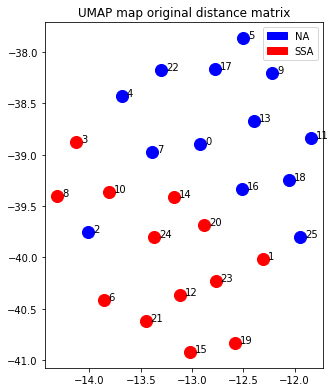

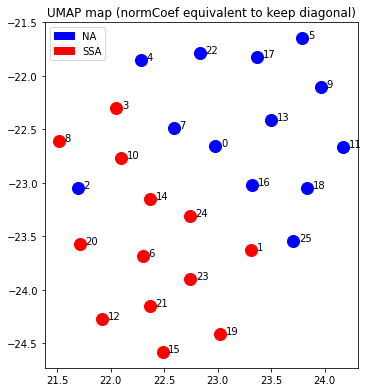

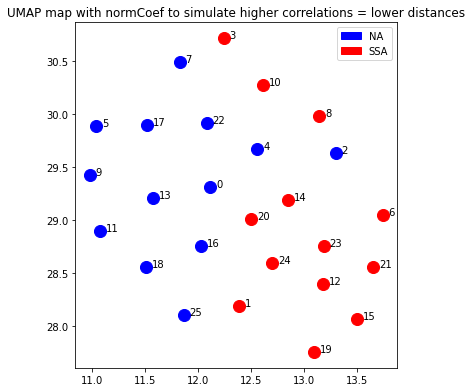

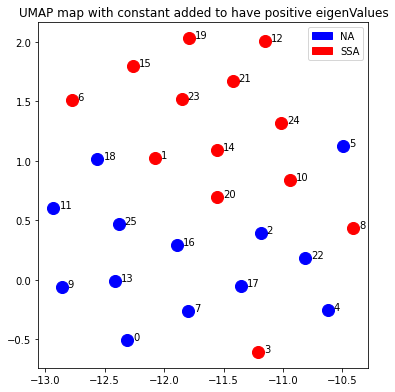

In [53]:
disparities = np.genfromtxt(os.path.join('disparities.csv'),delimiter=',')
disparities = np.array(disparities,dtype='float') # Convert into array
n_neighbors = 15

def compareUMAP():
    np.random.seed(42)
    distance_matrix = computeDistanceMatrix(1,addCoef=0,keepDiag=True)
    #distance_matrix = disparities
    points = computeUMAPCoordinate(distance_matrix,sslLabel,n_neighbors=n_neighbors)
    points = transformPoints(points)
    plotPoints(points,title='UMAP map original distance matrix')

    np.random.seed(42)
    plt.figure()
    distance_matrix = computeDistanceMatrix(45,addCoef=0,keepDiag=False)
    points = computeUMAPCoordinate(distance_matrix,sslLabel,n_neighbors=n_neighbors)
    points = transformPoints(points)
    plotPoints(points,title='UMAP map (normCoef equivalent to keep diagonal)')

    np.random.seed(42)
    plt.figure()
    distance_matrix = computeDistanceMatrix(1.2,addCoef=0,keepDiag=False)
    points = computeUMAPCoordinate(distance_matrix,sslLabel,n_neighbors=n_neighbors)
    points = transformPoints(points)
    plotPoints(points,title='UMAP map with normCoef to simulate higher correlations = lower distances')
    
    np.random.seed(42)
    plt.figure()
    distance_matrix = computeDistanceMatrix(45,addCoef=4,keepDiag=False)
    points = computeUMAPCoordinate(distance_matrix,sslLabel,n_neighbors=n_neighbors)
    points = transformPoints(points)
    plotPoints(points,title='UMAP map with constant added to have positive eigenValues')
    
compareUMAP()

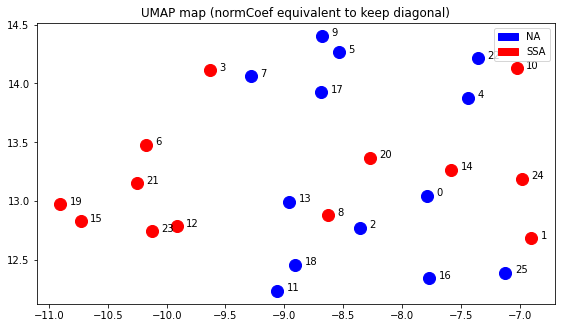

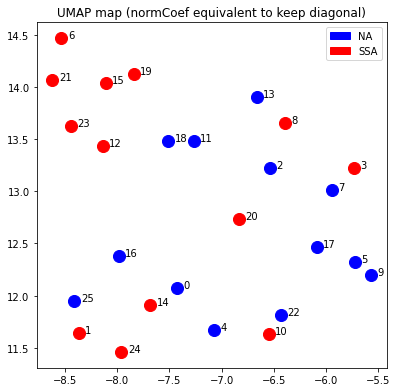

In [54]:
np.random.seed(42)
distance_matrix = computeDistanceMatrix(norm_coef,addCoef=add_coef)
#print(distance_matrix)
fitter = umap.UMAP(n_neighbors=3,metric='precomputed',min_dist=0.0,init='random',n_epochs=5000).fit(distance_matrix)
points = fitter.embedding_
points = transformPoints(points)
plotPoints(points,title='UMAP map (normCoef equivalent to keep diagonal)')

plt.figure()
np.random.seed(42)
distance_matrix = computeDistanceMatrix(norm_coef,addCoef=add_coef)
points = computePCoACoordinate(distance_matrix,N-1)
#print(euclidean_distances(points))
fitter = umap.UMAP(n_neighbors=3,metric='euclidean',min_dist=0.0,init='random',n_epochs=5000).fit(points)
points = fitter.embedding_
points = transformPoints(points)
plotPoints(points,title='UMAP map (normCoef equivalent to keep diagonal)')

### UMAP with SSL

In [55]:
def bestClassified(result,k,method):
    foundNA = subjects[result.label==0]
    cluster0 = result.best_points[result.label==0]
    center0 = np.mean(cluster0,axis=0)
    foundSSA = subjects[result.label==1]
    cluster1 = result.best_points[result.label==1]
    center1 = np.mean(cluster1,axis=0)
    
    if (method == 'closest to cluster center'):
        distArray0 = pairwise_distances(cluster0,np.tile(center0,(cluster0.shape[0],1)))[:,0]
        distArray1 = pairwise_distances(cluster1,np.tile(center1,(cluster1.shape[0],1)))[:,0]
        #print(foundNA[kargmin(distArray0, k)])
        #print(foundSSA[kargmin(distArray1, k)])

        return foundNA[kargmin(distArray0, k)], foundSSA[kargmin(distArray1, k)]
    
    elif (method == 'farthest from other cluster center'):
        distArray0 = pairwise_distances(cluster0,np.tile(center1,(cluster0.shape[0],1)))[:,0]
        distArray1 = pairwise_distances(cluster1,np.tile(center0,(cluster1.shape[0],1)))[:,0]
        #print(foundNA[kargmax(distArray0, k)])
        #print(foundSSA[kargmax(distArray1, k)])

        return foundNA[kargmax(distArray0, k)], foundSSA[kargmax(distArray1, k)]
    
    elif (method == 'mixed'):
        distArray0Center0 = pairwise_distances(cluster0,np.tile(center0,(cluster0.shape[0],1)))[:,0]
        distArray1Center1 = pairwise_distances(cluster1,np.tile(center1,(cluster1.shape[0],1)))[:,0]
        distArray0Center1 = pairwise_distances(cluster0,np.tile(center1,(cluster0.shape[0],1)))[:,0]
        distArray1Center0 = pairwise_distances(cluster1,np.tile(center0,(cluster1.shape[0],1)))[:,0]
        #print(foundNA[kargmax(distArray0, k)])
        #print(foundSSA[kargmax(distArray1, k)])

        return foundNA[kargmin(distArray0Center0/distArray0Center1, k)], foundSSA[kargmin(distArray1Center1/distArray1Center0, k)]
    
def kmax(array, k):
    tmp = np.copy(array)
    tmp = np.sort(tmp)
    return np.flip(tmp[len(tmp)-k:])

def kargmax(array, k):
    tmp = np.copy(array)
    tmp = np.argsort(tmp)
    return np.flip(tmp[len(tmp)-k:])

0%
[ 1  2  4 18]
[ 0  3  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 23 24 25]
0.8461538461538461
[0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1.
 1. 0.]
[0 1 1 0 0 0 1 0 0 0 1 0 1 0 1 1 0 0 1 1 1 1 0 1 1 0]
[0 1 1 0 0 0 1 0 0 0 1 0 1 0 1 1 0 0 1 1 1 1 0 1 1 0]
[0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1 0]


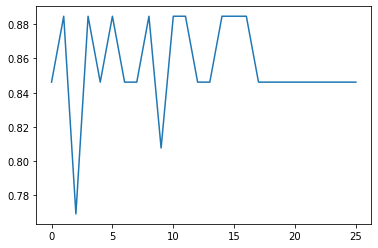

In [56]:
nRun = 1
from sklearn.cluster import KMeans

#method = 'closest to cluster center'
method = 'farthest from other cluster center'
method = 'mixed'

kmeansSSL_result = MapMethodResults("Kmeans SSL",random_init,n_neighbors = 8)
for i in range(nRun):
    print(str(int(i*100/nRun)) + "%")
    sslLabel = -1*np.ones(N)
    sslLabel = None
    SemiSLAccuracy = -1*np.zeros(N)
    
    for p in range(N):
        kmeansSSL_result.sslLabel = sslLabel
        kmeans = KMeans(n_clusters=2,n_init=100)
        #kmeans = SpectralClustering(n_clusters=2,n_init=100)
        #kmeans = GaussianMixture(n_components=2,n_init=100)
        #kmeans = OPTICS(min_samples=3)
        #,n_init=1000*(p==0)+1
        kmeansSSL_result.applyMethod(kmeans,dim=[8],verbose=False) # 2D max I think, otherwise curse of dimensionnality
        if (p==0):
            sslLabel = -1*np.ones(N)
        nb = np.max([np.sum(kmeansSSL_result.label==0),np.sum(kmeansSSL_result.label==1)])
        for k in range(1,nb+1):
            NAToLabel,SSAToLabel = bestClassified(kmeansSSL_result,k,method)
            if ((np.max(sslLabel[NAToLabel][(k-1)%len(NAToLabel)])!=-1 and np.max(sslLabel[SSAToLabel][(k-1)%len(SSAToLabel)])!=-1)==False):
                break
        sslLabel[NAToLabel] = 0
        sslLabel[SSAToLabel] = 1
        SemiSLAccuracy[p] = np.max(kmeansSSL_result.accuracy)
        if (p==0):
            points = kmeansSSL_result.best_points
            kmeansSSL_result.trueWrongClusters()
            print(kmeansSSL_result.misClassified)
            print(kmeansSSL_result.wellClassified)
        if (p==N-1):
            print(SemiSLAccuracy[p])

    kmeansSSL_result.probaLabel += sslLabel/nRun
    if (nRun == 1):
        plt.plot(SemiSLAccuracy)

print(kmeansSSL_result.probaLabel)
kmeansSSL_result.label = np.where(kmeansSSL_result.probaLabel<0.5,0,1)
print(kmeansSSL_result.label)

acc = sum(condition==kmeansSSL_result.label)/N
if (acc<0.5):
    kmeansSSL_result.label = 1-kmeansSSL_result.label
    kmeansSSL_result.accuracy[0,0] = 1-acc
else:
    kmeansSSL_result.accuracy[0,0] = acc
    
print(kmeansSSL_result.label)
print(condition)

Results

Best dimension 8 (7 means t-SNE)
Best normalisation 45 
Found clusters 
[0 1 1 0 0 0 1 0 0 0 1 0 1 0 1 1 0 0 1 1 1 1 0 1 1 0]
True clusters 
[0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1 0]
Well classified
[ 0  1  4  5  6  7  9 10 11 12 13 14 15 16 17 19 20 21 22 23 24 25]
Wrong classified
[ 2  3  8 18]
Best Kmeans SSL accuracy : 0.846154
Silhouette coefficient : 0.985
[0 1 1 0 0 0 1 0 0 0 1 0 1 0 1 1 0 0 1 1 1 1 0 1 1 0]


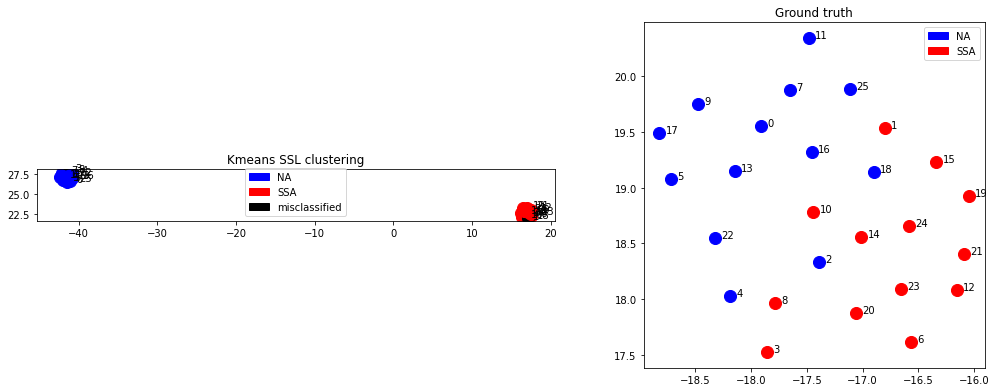

In [57]:
kmeansSSL_result.twoClustersMethodResult()


kmeansSSL_result.label = np.where(kmeansSSL_result.probaLabel<0.5,0,1)
print(kmeansSSL_result.label)

kmeansSSL_result.showResultMap()

plotPoints(points)

### UMAP gradually adding participants

[14 13 20  2 24 17 22  5 18  0 15  6 23  9 21  3 12 16 25  8  1 10  7 19
  4 11]


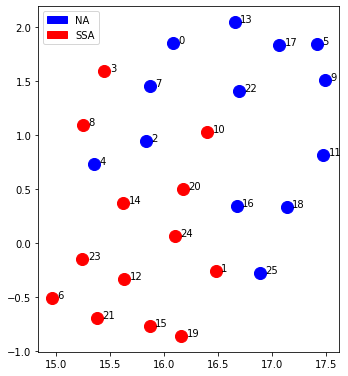

In [58]:
sortedIdx = bestClassifiedOverAll(kmeansSSL_result,N)
print(sortedIdx)
mat = np.copy(study_matrix[sortedIdx,:])
mat = mat[:,sortedIdx]


p = 26
mat = mat[:p,:p]

distance_matrix = computeDistanceMatrix(1,addCoef=0,keepDiag=True,study_matrix=mat)
points = computeUMAPCoordinate(distance_matrix,None,n_neighbors=8)
plotPoints(points,title='',subjects=sortedIdx)


[ 0  2  4  5  7  9 11 13 16 17 18 22 25  1  3  6  8 10 12 14 15 19 20 21
 23 24]


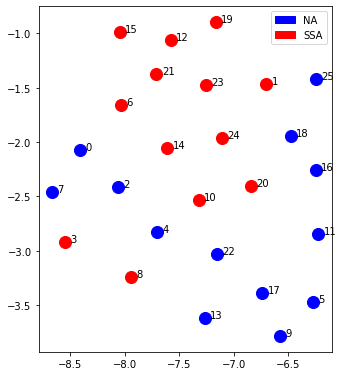

In [59]:
sortedIdx = np.concatenate((narrative,stimulus))
print(sortedIdx)
mat = np.copy(study_matrix[sortedIdx,:])
mat = mat[:,sortedIdx]


p = 26
mat = mat[:p,:p]
distance_matrix = computeDistanceMatrix(1,addCoef=0,keepDiag=True,study_matrix=mat)
points = computeUMAPCoordinate(distance_matrix,None,n_neighbors=15)
plotPoints(points,title='',subjects=sortedIdx)


### COP K-Means

In [60]:
def makePairs(arr, n): 
    # Set to store unique pairs 
    s = []
  
    # Make all possible pairs 
    for i in range(n): 
        for j in range(i+1,n): 
            s.append((arr[i], arr[j]))
  
    return s

#a = np.arange(0,N,1)
#sslLabel = -1*np.ones(N)
#sslLabel[a] = condition[a]
#np.random.shuffle(sslLabel)

def linkSemi(sslLabel):
    must_link0 = subjects[sslLabel==0]
    #print(must_link0)
    must_link0 = makePairs(must_link0, len(must_link0))

    must_link1 = subjects[sslLabel==1]
    #print(must_link1)
    must_link1 = makePairs(must_link1, len(must_link1))

    must_link = must_link0 + must_link1
    #print(must_link)

    cannot_link = []
    for i in range(len(subjects[sslLabel==1])):
        for j in range(len(subjects[sslLabel==0])):
            cannot_link.append((subjects[sslLabel==1][i],subjects[sslLabel==0][j]))

    #print(cannot_link)
    
    return must_link,cannot_link

0%
[ 0  1  2  5  6  7  9 11 12 13 14 15 17 18 19 21 22 23 24]
[ 3  4  8 10 16 20 25]
0.2692307692307692
[1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0.
 0. 0.]
[1 0 1 1 0 1 0 1 1 1 1 1 0 1 0 0 0 1 1 0 1 0 1 0 0 0]


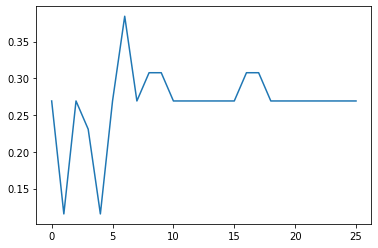

In [61]:
from COPKmeans import COPKmeans

nRun = 1

kmeansSSL_result = MapMethodResults("Kmeans SSL",random_init,n_neighbors = 4)
for i in range(nRun):
    print(str(int(i*100/nRun)) + "%")
    sslLabel = -1*np.ones(N)
    sslLabel = None
    SemiSLAccuracy = -1*np.zeros(N)
    
    for p in range(N):
        must_link,cannot_link = linkSemi(sslLabel)
        kmeans = COPKmeans(n_clusters=2,must_link=must_link,cannot_link=cannot_link,n_init=1000*(p==0)+1)
        kmeansSSL_result.applyMethod(kmeans,dim=[8],verbose=False) # 2D max I think, otherwise curse of dimensionnality
        
        if (p==0):
            sslLabel = -1*np.ones(N)
        nb = np.max([np.sum(kmeansSSL_result.label==0),np.sum(kmeansSSL_result.label==1)])
        for k in range(1,nb+1):
            NAToLabel,SSAToLabel = bestClassified(kmeansSSL_result,k,'closest to cluster center')
            if ((np.max(sslLabel[NAToLabel][(k-1)%len(NAToLabel)])!=-1 and np.max(sslLabel[SSAToLabel][(k-1)%len(SSAToLabel)])!=-1)==False):
                break
        sslLabel[NAToLabel] = 0
        sslLabel[SSAToLabel] = 1
        SemiSLAccuracy[p] = np.max(kmeansSSL_result.accuracy)
        if (p==0):
            points = kmeansSSL_result.best_points
            kmeansSSL_result.trueWrongClusters()
            print(kmeansSSL_result.misClassified)
            print(kmeansSSL_result.wellClassified)
        if (p==N-1):
            print(SemiSLAccuracy[p])
        
        '''
        acc = sum(condition==kmeansSSL_result.label)/N
        print(kmeansSSL_result.label)
        print(acc)
        '''

    kmeansSSL_result.probaLabel += sslLabel/nRun
    if (nRun == 1):
        plt.plot(SemiSLAccuracy)

print(kmeansSSL_result.probaLabel)
kmeansSSL_result.label = np.where(kmeansSSL_result.probaLabel<0.5,0,1)
print(kmeansSSL_result.label)

acc = sum(condition==kmeansSSL_result.label)/N
if (acc<0.5):
    kmeansSSL_result.label = 1-kmeansSSL_result.label
    kmeansSSL_result.accuracy[0,0] = 1-acc
else:
    kmeansSSL_result.accuracy[0,0] = acc

Results

Best dimension 8 (7 means t-SNE)
Best normalisation 45 
Found clusters 
[0 1 0 0 1 0 1 0 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1]
True clusters 
[0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1 0]
Well classified
[ 0  1  2  5  6  7  9 11 12 13 14 15 17 18 19 21 22 23 24]
Wrong classified
[ 3  4  8 10 16 20 25]
Best Kmeans SSL accuracy : 0.730769
Silhouette coefficient : 0.255
[1 0 1 1 0 1 0 1 1 1 1 1 0 1 0 0 0 1 1 0 1 0 1 0 0 0]


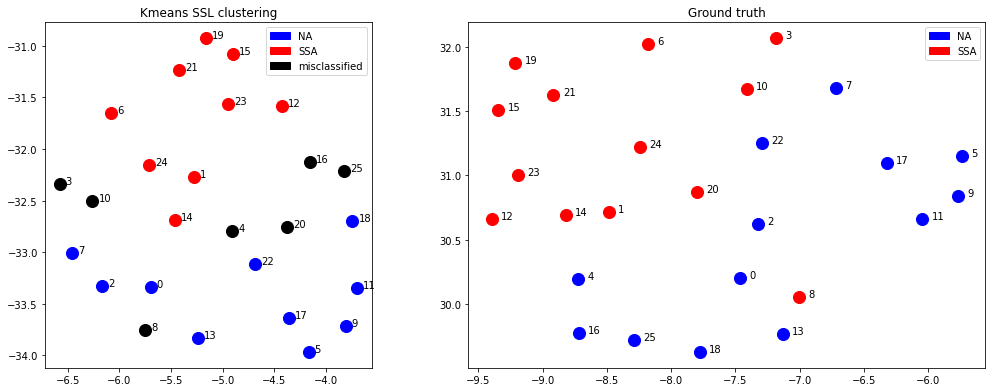

In [62]:
kmeansSSL_result.twoClustersMethodResult()


kmeansSSL_result.label = np.where(kmeansSSL_result.probaLabel<0.5,0,1)
print(kmeansSSL_result.label)

kmeansSSL_result.showResultMap()

plotPoints(points)

## Fuzzy cmeans

//anaconda3/lib/python3.7/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.18509430357757795 and the largest is 1.2606717862993162.
  RuntimeWarning


0.7692307692307692
[ 2  3  8 10 16 18]
0.6538461538461539
[ 1  3  4  5  6  7  8  9 10 11 13 15 16 17 18 19 22]


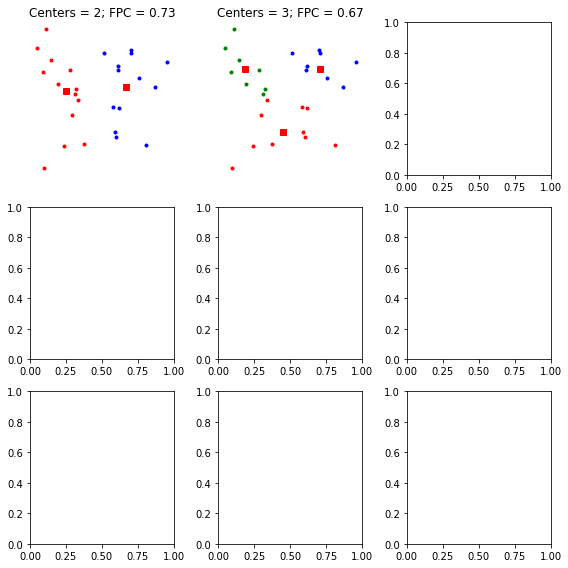

In [63]:
import skfuzzy as fuzz

# Set up the loop and plot
fig1, axes1 = plt.subplots(3, 3, figsize=(8, 8))

fpcs = []

distance_matrix = computeDistanceMatrix(1.2,addCoef=0,keepDiag=False)
points = computePCoACoordinate(distance_matrix,2)
points = transformPoints(points)
#plotPoints(points,title='',subjects=sortedIdx)

for ncenters, ax in enumerate(axes1.reshape(-1), 2):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        points.T, ncenters, 2, error=0.005, maxiter=1000, init=None)

    # Store fpc values for later
    fpcs.append(fpc)

    # Plot assigned clusters, for each data point in training set
    cluster_membership = np.argmax(u, axis=0)
    for j in range(ncenters):
        ax.plot(points[:,0][cluster_membership == j],
                points[:,1][cluster_membership == j], '.', color='blue'*(j==0)+'red'*(j==1)+'green'*(j==2))

    acc = sum(condition==cluster_membership)/N
    if (acc<0.5):
        acc = 1-acc
        cluster_membership = 1-cluster_membership
    print(acc)
    print(subjects[condition!=cluster_membership])
    # Mark the center of each fuzzy cluster
    for pt in cntr:
        ax.plot(pt[0], pt[1], 'rs')

    ax.set_title('Centers = {0}; FPC = {1:.2f}'.format(ncenters, fpc))
    ax.axis('off')
    if (ncenters>2):
        break

fig1.tight_layout()

## DBSCAN (here with option "precomputed metric" -> array of distances)

In [64]:
from sklearn.cluster import DBSCAN

# Compute DBSCAN
distance_matrix = computeDistanceMatrix(norm_coef,addCoef=add_coef)
db = DBSCAN(eps=1, min_samples=3,metric='precomputed').fit(distance_matrix)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 1


In [65]:
# Compute DBSCAN
distance_matrix = computeDistanceMatrix(norm_coef,addCoef=add_coef)
points = computeUMAPCoordinate(distance_matrix)
db = DBSCAN(min_samples=3,metric='correlation').fit(points)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 1


no plot


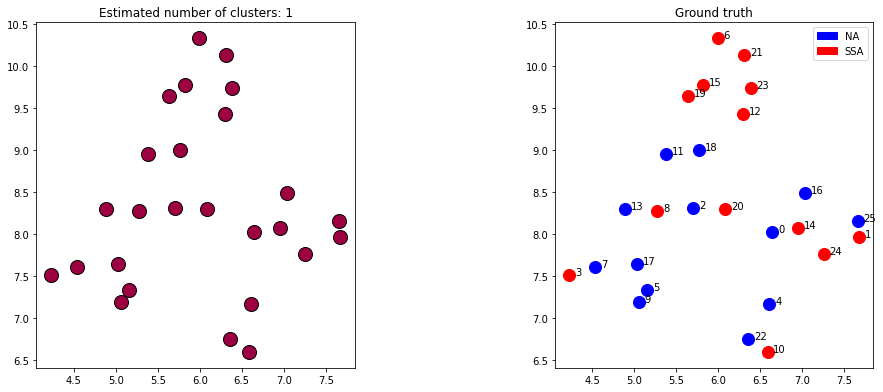

In [66]:
# Black removed and is used OPTICSr noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

ax = plt.axes([0,0,1.2,1.2])
ax.set_aspect(aspect='equal')

for k, col in zip(unique_labels, colors):

    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    xy = points[class_member_mask & core_samples_mask]
    try:
        plt.plot(xy[:, 0], points[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)
    except:
        print("no plot")
    xy = points[class_member_mask & ~core_samples_mask]
    try:
        plt.plot(xy[:, 0], points[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)
    except:
        print("no plot")
        
plt.title('Estimated number of clusters: %d' % n_clusters_)

# Compare to ground truth
plotPoints(points,projection=True)

## OPTICS (here with option "precomputed metric" -> array of distances)

In [67]:
from sklearn.cluster import OPTICS

nRun = 10
random_init = True
compute = False

if (compute):
    # coefficients = np.linspace(1,45,2)
    coefficients = [45] # Changing normalisation coefficient does not change mapping if add_coef large enough 
                        # (2 is ok for that and for only positive eigen values EEG)

    optics_result = DistanceMethodResults("OPTICS",random_init)
    if (random_init): # Make several runs
        optics = OPTICS(min_samples=3,metric='precomputed')
        optics_result.applyMethodAverage(optics,dim=2,coef=norm_coef,n_run=nRun) # 2D max I think, otherwise curse of dimensionnality 
        #optics_result.applyMethodAverage(optics,coef=norm_coef,n_run=nRun,verbose=False) # 2D max I think, otherwise curse of dimensionnality
    else:
        optics = OPTICS(min_samples=3,metric='precomputed')
        optics_result.applyMethodAverage(optics,coef=norm_coef) # 2D max I think, otherwise curse of dimensionnality

    # Show results
    optics_result.twoClustersMethodResult()
    if 'OPTICS' not in methodUsed:
        accuracyVect = np.append(accuracyVect,optics_result.best_accuracy)
        SCVect = np.append(SCVect,optics_resuls.SC)
        methodUsed = np.append(methodUsed,'OPTICS')
        prior = np.append(prior,'dist')

In [68]:
distance_matrix = computeDistanceMatrix(1.001,addCoef=0,keepDiag=False)
db = OPTICS(min_samples=1,metric='euclidean').fit(distance_matrix)
db.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

In [69]:
from sklearn.cluster import OPTICS

nRun = 10
random_init = False
mds_random_init = False # MDS with several random init
nMDSRun = 50 # Number of mds runs with different random init if mds_random_init True
compute = True

if (compute):
    # coefficients = np.linspace(1,45,2)
    coefficients = [45] # Changing normalisation coefficient does not change mapping if add_coef large enough 
                        # (2 is ok for that and for only positive eigen values EEG)

    optics_result = MapMethodResults("OPTICS",random_init)
    if (random_init): # Make several runs
        if (mds_random_init): # MDS  
            optics = OPTICS(min_samples=3)
            optics_result.applyMethodAndMDSAverages(optics,dim=2,coef=norm_coef,n_run=nRun,n_mds_run=nMDSRun) # 2D max I think, otherwise curse of dimensionnality
        else:
            optics = OPTICS(min_samples=3)
            optics_result.applyMethodAverage(optics,dim=2,coef=norm_coef,n_run=nRun) # 2D max I think, otherwise curse of dimensionnality
    else: # Compare effect of normalization and dimension
        optics = OPTICS(min_samples=3)
        optics_result.applyMethod(optics,dim=[8]) # 2D max I think, otherwise curse of dimensionnality

Computing clustering

0%


Results

Best dimension 8 (7 means t-SNE)
Best normalisation 45 
Found clusters 
[ 0  3  0 -1 -1  1 -1  0  0  1 -1 -1  2  0  0  2 -1  1  2  2  0  2 -1  2
  3  3]
True clusters 
[0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1 0]
Well classified
[ 0  2  7 13]
Wrong classified
[ 1  3  4  5  6  8  9 10 11 12 14 15 16 17 18 19 20 21 22 23 24 25]
Best OPTICS accuracy : 0.153846
Silhouette coefficient : 0.157
DB index : 1.869115 
norm : 2.884654
norm : 2.603695
1


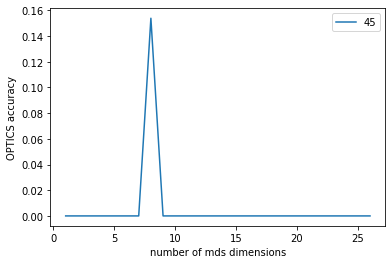

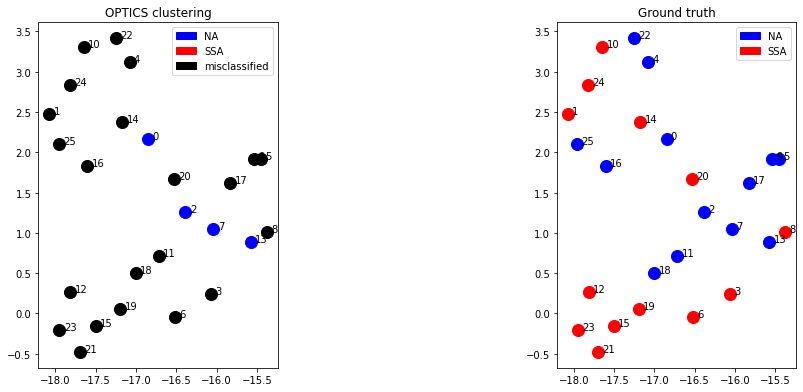

In [70]:
# Show results

if (compute):
    if (random_init==False):
        optics_result.clusteringAccuracyWithDimension()
    optics_result.twoClustersMethodResult()
    optics_result.showResultMap()
    plotPoints(optics_result.best_points)
    #plt.scatter(kmeans.init[:,0],kmeans.init[:,1],s=200,marker='x') # if t-SNE and 1 coef
    print("DB index : %f " %optics_result.dbScore())
    optics_result.writeProbaLabel()
    if 'k-means' not in methodUsed:
        accuracyVect = np.append(accuracyVect,optics_result.best_accuracy)
        SCVect = np.append(SCVect,optics_result.SC)
        methodUsed = np.append(methodUsed,'k-means')
        prior = np.append(prior,('t-SNE')*(optics_result.best_dim==7)+('PCoA '+str(abs(optics_result.best_dim)))*(optics_result.best_dim<0)+('MDS '+str(optics_result.best_dim))*(optics_result.best_dim<7)*(optics_result.best_dim>0))
        
probaLabel = np.array([0.356, 0.643 ,0.589, 0.422, 0.425, 0.331, 0.762, 0.338, 0.434, 0.229, 0.499, 0.334
, 0.829 ,0.237, 0.755, 0.79,  0.413, 0.265 ,0.616 ,0.707, 0.753 ,0.827 ,0.322 ,0.783
, 0.67 , 0.442])
print("norm : %f" %np.linalg.norm(probaLabel-optics_result.probaLabel))
print("norm : %f" %np.linalg.norm(probaLabel-(1-optics_result.probaLabel)))

print(len(optics_result.allLabel))


## Mean Shift (to do on coordinates)

number of estimated clusters : 2
group 0
[ 0  2  3  5  7  8  9 10 11 13 17 18 20 22]
group 1
[ 1  4  6 12 14 15 16 19 21 23 24 25]
NA
[ 0  2  4  5  7  9 11 13 16 17 18 22 25]
SSA
[ 1  3  6  8 10 12 14 15 19 20 21 23 24]


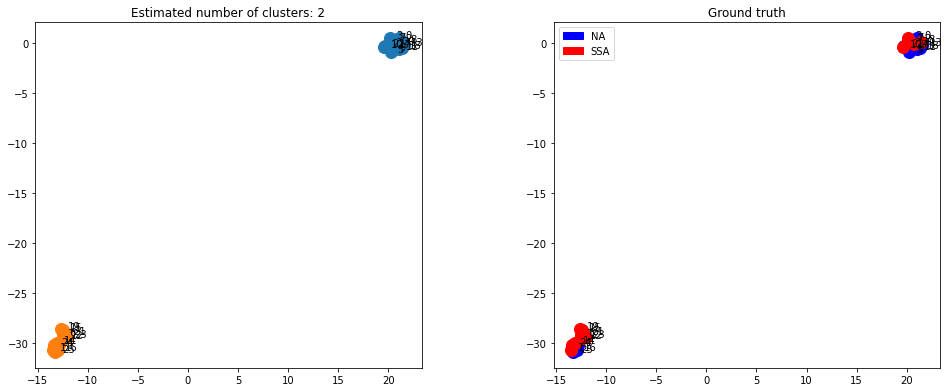

In [71]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Compute clustering with MeanShift
distance_matrix = computeDistanceMatrix(norm_coef,addCoef=add_coef)
#points = computeSNECoordinate(distance_matrix)
points = computeUMAPCoordinate(distance_matrix,sslLabel)

# Compare to ground truth
plotPoints(points,projection=True)

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(points, quantile=0.5) # 0.35 : heuristically found to have 2 clusters

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(points)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

# Plot result
from itertools import cycle

ax = plt.axes([0,0,1.2,1.2])
ax.set_aspect(aspect='equal')
#points = transformPoints(points)

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    print("group %i" %k)
    print(subjects[my_members])
    cluster_center = cluster_centers[k]
    ax.scatter(points[my_members, 0], points[my_members, 1], s=145)
    
    subjects = np.arange(0,N)
    for i in subjects[my_members==1]:
        ax.annotate(i,(points[i,0],points[i,1]),xytext=(points[i,0]+(np.max(points[:,0])-np.min(points[:,0]))/50,points[i,1]))
    
    plt.title('Estimated number of clusters: %d' % n_clusters_)
    
print("NA")
print(narrative)
print("SSA")
print(stimulus)

## 2-cluster methods

### K-Means

In [72]:
from sklearn.cluster import KMeans

nRun = 10
random_init = False
mds_random_init = False # MDS with several random init
nMDSRun = 50 # Number of mds runs with different random init if mds_random_init True
compute = True

if (compute):
    # coefficients = np.linspace(1,45,2)
    coefficients = [45] # Changing normalisation coefficient does not change mapping if add_coef large enough 
                        # (2 is ok for that and for only positive eigen values EEG)

    kmeans_result = MapMethodResults("k-means",random_init,n_neighbors = 4)
    if (random_init): # Make several runs
        if (mds_random_init): # MDS  
            kmeans = KMeans(n_clusters=2,n_init=1)
            kmeans_result.applyMethodAndMDSAverages(kmeans,dim=2,coef=norm_coef,n_run=nRun,n_mds_run=nMDSRun) # 2D max I think, otherwise curse of dimensionnality
        else:
            kmeans = KMeans(n_clusters=2,n_init=1)
            kmeans_result.applyMethodAverage(kmeans,dim=2,coef=norm_coef,n_run=nRun) # 2D max I think, otherwise curse of dimensionnality
    else: # Compare effect of normalization and dimension
        # kmeans = KMeans(n_clusters=2,n_init=1) # init array used before fit
        kmeans = KMeans(n_clusters=2,n_init=100)
        kmeans_result.applyMethod(kmeans,dim=[-2]) # 2D max I think, otherwise curse of dimensionnality

Computing clustering

0%


Results

Best dimension -2 (7 means t-SNE)
Best normalisation 45 
Found clusters 
[0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 1 1 0 1 1 1 1 0 1 1 0]
True clusters 
[0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1 0]
Well classified
[ 0  1  4  5  6  7  9 11 12 13 14 15 17 19 20 21 22 23 24 25]
Wrong classified
[ 2  3  8 10 16 18]
Best k-means accuracy : 0.769231
Silhouette coefficient : 0.368
DB index : 1.086099 
norm : 2.884654
norm : 2.603695
1


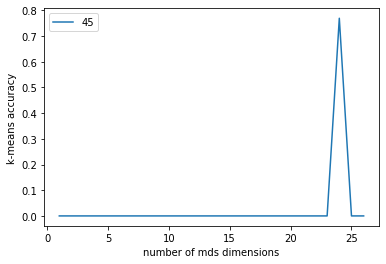

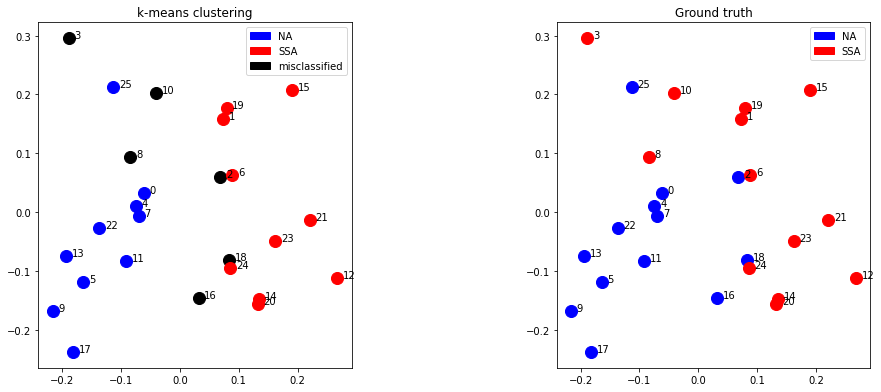

In [73]:
# Show results

if (compute):
    if (random_init==False):
        kmeans_result.clusteringAccuracyWithDimension()
    kmeans_result.twoClustersMethodResult()
    kmeans_result.showResultMap()
    plotPoints(kmeans_result.best_points)
    #plt.scatter(kmeans.init[:,0],kmeans.init[:,1],s=200,marker='x') # if t-SNE and 1 coef
    print("DB index : %f " %kmeans_result.dbScore())
    kmeans_result.writeProbaLabel()
    if 'k-means' not in methodUsed:
        accuracyVect = np.append(accuracyVect,kmeans_result.best_accuracy)
        SCVect = np.append(SCVect,kmeans_result.SC)
        methodUsed = np.append(methodUsed,'k-means')
        prior = np.append(prior,('t-SNE')*(kmeans_result.best_dim==7)+('PCoA '+str(abs(dim)))*(kmeans_result.best_dim<0)+('MDS '+str(dim))*(kmeans_result.best_dim<7)*(kmeans_result.best_dim>0))
        
probaLabel = np.array([0.356, 0.643 ,0.589, 0.422, 0.425, 0.331, 0.762, 0.338, 0.434, 0.229, 0.499, 0.334
, 0.829 ,0.237, 0.755, 0.79,  0.413, 0.265 ,0.616 ,0.707, 0.753 ,0.827 ,0.322 ,0.783
, 0.67 , 0.442])
print("norm : %f" %np.linalg.norm(probaLabel-kmeans_result.probaLabel))
print("norm : %f" %np.linalg.norm(probaLabel-(1-kmeans_result.probaLabel)))

print(len(kmeans_result.allLabel))


### Hierarchical clustering

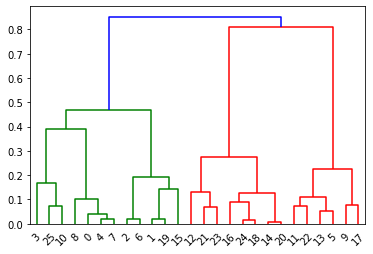

Found clusters 
[0 0 0 0 0 1 0 0 0 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0]
True clusters 
[0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1 0]
Well classified
[ 0  2  4  7 12 14 20 21 23 24 25]
Wrong classified
[ 1  3  5  6  8  9 10 11 13 15 16 17 18 19 22]
Accuracy : 0.423077
Silhouette coefficient : 0.001


In [74]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

distance_matrix = computeDistanceMatrix(norm_coef,addCoef=add_coef,uncondensed=True,keepDiag=True)
points = computePCoACoordinate(distance_matrix,2)
distance_matrix = euclidean_distances(points)
distance_matrix = ssd.squareform(distance_matrix,checks=False)
Z=linkage(distance_matrix,'ward','euclidean',optimal_ordering=True)
threshold = 6*(case!='EDA')+6*(case=='EDA') # 6 EEG if keepDiag==True
threshold = 0.82
dendrogram(Z, color_threshold=threshold)
plt.show()

print("Found clusters ")
label = (fcluster(Z, t=threshold, criterion='distance')-1)
label_HC = label
print(label)
print("True clusters ")
print(condition)

subjects = np.arange(0,N)
wellClassified = subjects[label==condition]
misClassified = subjects[label!=condition]
SSA_HC = subjects[label==1] # Maybe NA
NA_HC = subjects[label==0] # Maybe SSA
print("Well classified")
print(wellClassified)
print("Wrong classified")
print(misClassified)
accuracy = len(wellClassified)/N
print("Accuracy : %f" %accuracy)
#[ 0  2  3  7  8 10 16 18 25]
distance_matrix = computeDistanceMatrix(norm_coef,addCoef=add_coef)
SC = silhouetteCoef(distance_matrix,label)
print("Silhouette coefficient : %0.3f" %SC)
if 'HC' not in methodUsed:
    accuracyVect = np.append(accuracyVect,accuracy)
    SCVect = np.append(SCVect,SC)
    methodUsed = np.append(methodUsed,'HC')
    prior = np.append(prior,'dist')

### Spectral Clustering

In [75]:
from sklearn.cluster import SpectralClustering

compute = False
random_init = True
mds_random_init = True

if (compute):
    # coefficients = np.linspace(1,45,2)
    coefficients = [45] # Changing normalisation coefficient does not change mapping if add_coef large enough 
                        # (2 is ok for that and for only positive eigen values EEG)

    spectralClustering_result = MapMethodResults("spectral clustering",random_init)
    gamma = 1
    if (random_init): # Make several runs
        if (mds_random_init): # MDS        
            spectralClustering = SpectralClustering(n_clusters=2,n_init=1,gamma=gamma)
            #[ 1  3  6  8 10 16]
            spectralClustering_result.applyMethodAndMDSAverages(spectralClustering,dim=2,coef=norm_coef,n_run=nRun,n_mds_run=nMDSRun) # 2D max I think, otherwise curse of dimensionnality
        else: # PCoA or t-SNE
            spectralClustering = SpectralClustering(n_clusters=2,n_init=1,gamma=gamma)
            spectralClustering_result.applyMethodAverage(spectralClustering,dim=2,coef=norm_coef,n_run=nRun) # 2D max I think, otherwise curse of dimensionnality
    else: # Compare effect of normalization and dimension
        spectralClustering = SpectralClustering(n_clusters=2, n_init=1000,gamma=gamma)
        spectralClustering_result.applyMethod(spectralClustering,dim=[-2]) # 2D max I think, otherwise curse of dimensionnality

In [76]:
# Show results
# ward HC : [ 0  2  3  7  8 10 16 18 25]
if (compute):
    if (random_init==False):
        spectralClustering_result.clusteringAccuracyWithDimension()
    spectralClustering_result.twoClustersMethodResult()
    spectralClustering_result.showResultMap()
    plotPoints(spectralClustering_result.best_points)
    print("DB index : %f " %spectralClustering_result.dbScore())
    spectralClustering_result.writeProbaLabel()
    if 'SC_map' not in methodUsed:
        accuracyVect = np.append(accuracyVect,spectralClustering_result.best_accuracy)
        SCVect = np.append(SCVect,spectralClustering_result.SC)
        methodUsed = np.append(methodUsed,'SC_map')
        prior = np.append(prior,('t-SNE')*(spectralClustering_result.best_dim==7)+('PCoA '+str(abs(dim)))*(spectralClustering_result.best_dim<0)+('MDS '+str(dim))*(spectralClustering_result.best_dim<7)*(spectralClustering_result.best_dim>0))

### GMM

In [77]:
from sklearn.mixture import GaussianMixture

compute = False
random_init = False
mds_random_init = False

if (compute):
    # coefficients = np.linspace(1,45,2)
    coefficients = [45] # Changing normalisation coefficient does not change mapping if add_coef large enough 
                        # (2 is ok for that and for only positive eigen values EEG)

    gmm_result = MapMethodResults("gaussian mixture",random_init)
    if (random_init): # Make several runs
        if (mds_random_init): # MDS  
            gmm = GaussianMixture(n_components=2,n_init=1)
            gmm_result.applyMethodAndMDSAverages(gmm,dim=2,coef=norm_coef,n_run=nRun,n_mds_run=nMDSRun) # 2D max I think, otherwise curse of dimensionnality
        else:
            gmm = GaussianMixture(n_components=2,n_init=1)
            gmm_result.applyMethodAverage(gmm,dim=2,coef=norm_coef,n_run=nRun) # 2D max I think, otherwise curse of dimensionnality
    else: # Compare effect of normalization and dimension
        gmm = GaussianMixture(n_components=2, n_init=1000)
        gmm_result.applyMethod(gmm,dim=[-2]) # 2D max I think, otherwise curse of dimensionnality

In [78]:
# Show results

if (compute):
    if (random_init==False):
        gmm_result.clusteringAccuracyWithDimension()
    gmm_result.twoClustersMethodResult()
    gmm_result.showResultMap()
    plotPoints(gmm_result.best_points)
    print("DB index : %f " %gmm_result.dbScore())
    gmm_result.writeProbaLabel()
    if 'GMM' not in methodUsed:
        accuracyVect = np.append(accuracyVect,gmm_result.best_accuracy)
        SCVect = np.append(SCVect,gmm_result.SC)
        methodUsed = np.append(methodUsed,'GMM')
        prior = np.append(prior,('t-SNE')*(gmm_result.best_dim==7)+('PCoA '+str(abs(dim)))*(gmm_result.best_dim<0)+('MDS '+str(dim))*(gmm_result.best_dim<7)*(gmm_result.best_dim>0))


## Semi-supervised learning (SSL)

### Label propagation

In [79]:
from sklearn.semi_supervised import LabelPropagation

compute = True
mds_random_init = False

if (compute):
    # coefficients = np.linspace(1,45,2)
    coefficients = [45] # Changing normalisation coefficient does not change mapping if add_coef large enough 
                        # (2 is ok for that and for only positive eigen values EEG)

    # -1 for unlabeled data
    
    try:
        sslLabel = (kmeans_result.robustLabel)*(kmeans_result.label)-1*(kmeans_result.robustLabel==0)
    except:
        sslLabel = (kmedoids_result.robustLabel)*(kmedoids_result.label)-1*(kmedoids_result.robustLabel==0)
    
    labelPropagation_result = MapMethodResults("Label propagation",random_init,sslLabel=sslLabel)
    if (mds_random_init): # Make several MDS runs
        labelPropagation = LabelPropagation(n_neighbors=4,max_iter=10000)
        labelPropagation_result.applyMethodAndMDSAverages(labelPropagation,dim=2,coef=norm_coef,n_run=nRun,n_mds_run=nMDSRun) # 2D max I think, otherwise curse of dimensionnality
    else: # Compare effect of normalization and dimension
        labelPropagation = LabelPropagation(n_neighbors=4,max_iter=10000)
        labelPropagation_result.applyMethod(labelPropagation,dim=[-2]) # 2D max I think, otherwise curse of dimensionnality

Computing clustering

0%


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Labels correspond to only 1 group
  


Results

Best dimension -2 (7 means t-SNE)
Best normalisation 45 
Found clusters 
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
True clusters 
[0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1 0]
Well classified
[ 1  3  6  8 10 12 14 15 19 20 21 23 24]
Wrong classified
[ 0  2  4  5  7  9 11 13 16 17 18 22 25]
Best Label propagation accuracy : 0.500000
Silhouette coefficient : -1.000


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:295: UserWarning: Labels correspond to only 1 group


DB index : -1.000000 


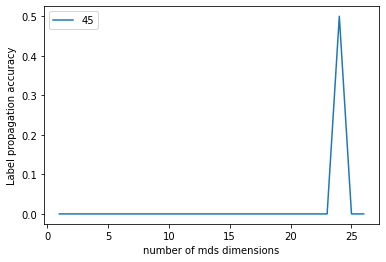

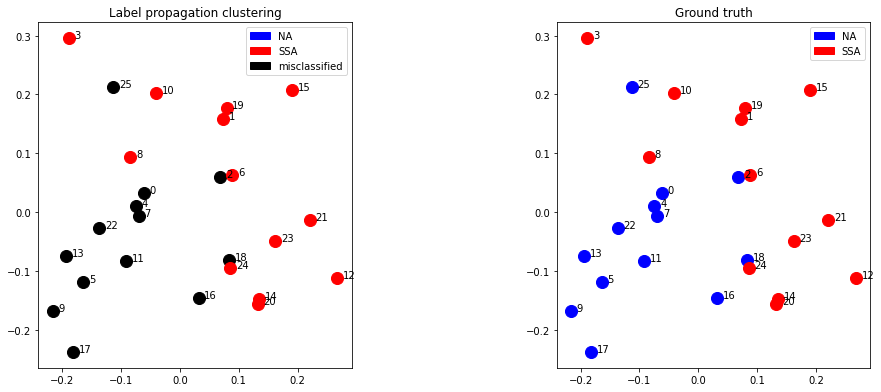

In [80]:
# Show results

if (compute):
    if (random_init==False):
        labelPropagation_result.clusteringAccuracyWithDimension()
    labelPropagation_result.twoClustersMethodResult()
    labelPropagation_result.showResultMap()
    plotPoints(labelPropagation_result.best_points)
    print("DB index : %f " %labelPropagation_result.dbScore())
    # kmeans robust [ 0  4  5  6  9 11 12 13 19 21 22 23 24]
    if 'label propagation' not in methodUsed:
        accuracyVect = np.append(accuracyVect,labelPropagation_result.best_accuracy)
        SCVect = np.append(SCVect,labelPropagation_result.SC)
        methodUsed = np.append(methodUsed,'label propagation')
        prior = np.append(prior,('t-SNE')*(labelPropagation_result.best_dim==7)+('PCoA '+str(dim))*(labelPropagation_result.best_dim<7))    

### Label spreading

In [81]:
from sklearn.semi_supervised import LabelSpreading

compute = True

if (compute):
    # coefficients = np.linspace(1,45,2)
    coefficients = [45] # Changing normalisation coefficient does not change mapping if add_coef large enough 
                        # (2 is ok for that and for only positive eigen values EEG)

    # -1 for unlabeled data
    '''
    try:
        sslLabel = (kmeans_result.robustLabel)*(kmeans_result.label)-1*(kmeans_result.robustLabel==0)
    except:
        sslLabel = (kmedoids_result.robustLabel)*(kmedoids_result.label)-1*(kmedoids_result.robustLabel==0)
    '''
    sslLabel = (kmedoids_result.robustLabel)*(kmedoids_result.label)-1*(kmedoids_result.robustLabel==0)
    
    labelSpreading_result = MapMethodResults("Label spreading",random_init,sslLabel=sslLabel)
    if (mds_random_init): # Make several MDS runs
        labelSpreading = LabelSpreading(n_neighbors=4,max_iter=10000)
        labelSpreading_result.applyMethodAndMDSAverages(labelSpreading,dim=2,coef=norm_coef,n_run=nRun,n_mds_run=nMDSRun) # 2D max I think, otherwise curse of dimensionnality
    else: # Compare effect of normalization and dimension
        labelSpreading = LabelSpreading(n_neighbors=4,max_iter=10000)
        labelSpreading_result.applyMethod(labelSpreading,dim=[-2]) # 2D max I think, otherwise curse of dimensionnality

Computing clustering

0%


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Labels correspond to only 1 group
  


Results

Best dimension -2 (7 means t-SNE)
Best normalisation 45 
Found clusters 
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
True clusters 
[0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1 0]
Well classified
[ 1  3  6  8 10 12 14 15 19 20 21 23 24]
Wrong classified
[ 0  2  4  5  7  9 11 13 16 17 18 22 25]
Best Label spreading accuracy : 0.500000
Silhouette coefficient : -1.000
DB index : -1.000000 


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:295: UserWarning: Labels correspond to only 1 group


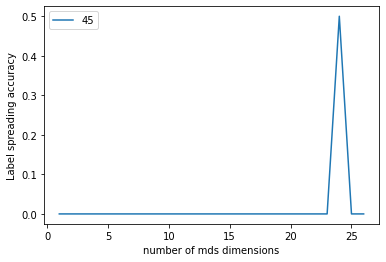

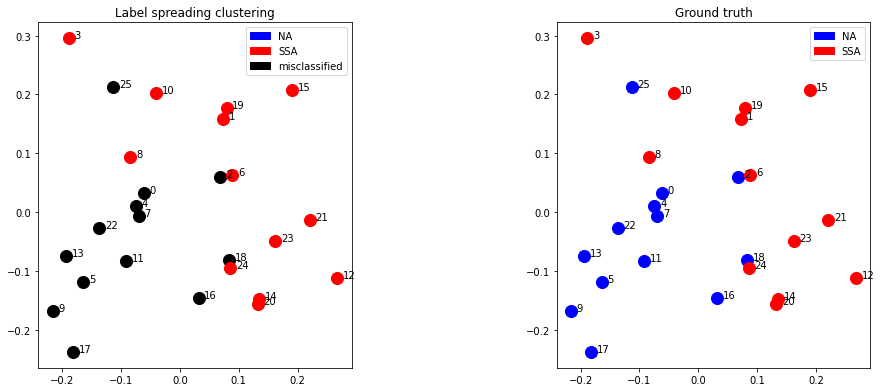

In [82]:
# Show results

if (compute):
    if (random_init==False):
        labelSpreading_result.clusteringAccuracyWithDimension()
    labelSpreading_result.twoClustersMethodResult()
    labelSpreading_result.showResultMap()
    plotPoints(labelSpreading_result.best_points)
    print("DB index : %f " %labelSpreading_result.dbScore())
    # kmeans robust [ 0  4  5  6  9 11 12 13 19 21 22 23 24]
    if 'label spreading' not in methodUsed:
        accuracyVect = np.append(accuracyVect,labelSpreading_result.best_accuracy)
        SCVect = np.append(SCVect,labelSpreading_result.SC)
        methodUsed = np.append(methodUsed,'label spreading')
        prior = np.append(prior,('t-SNE')*(labelSpreading_result.best_dim==7)+('PCoA '+str(dim))*(labelSpreading_result.best_dim<7))    

### COP-Kmeans

In [83]:
from COPKmeans import COPKmeans

compute = True
mds_random_init = False
random_init = False
nRun = 10
nMDSRun = 100

if (compute):
    must_link,cannot_link = linkSemi(sslLabel)
    # coefficients = np.linspace(1,45,2)
    coefficients = [45] # Changing normalisation coefficient does not change mapping if add_coef large enough 
                        # (2 is ok for that and for only positive eigen values EEG)

    copkmeans_result = MapMethodResults("COP-Kmeans",random_init)
    if (random_init): # Make several runs
        if (mds_random_init): # MDS  
            copkmeans = COPKmeans(n_clusters=2,must_link=must_link,cannot_link=cannot_link)
            copkmeans_result.applyMethodAndMDSAverages(copkmeans,dim=2,coef=norm_coef,n_run=nRun,n_mds_run=nMDSRun) # 2D max I think, otherwise curse of dimensionnality
        else:
            copkmeans = COPKmeans(n_clusters=2,must_link=must_link,cannot_link=cannot_link)
            copkmeans_result.applyMethodAverage(copkmeans,dim=2,coef=norm_coef,n_run=nRun) # 2D max I think, otherwise curse of dimensionnality
    else: # Compare effect of normalization and dimension
        # copkmeans = COPKmeans(n_clusters=2,n_init=1) # init array used before fit
        copkmeans = COPKmeans(n_clusters=2,must_link=must_link,cannot_link=cannot_link,n_init=100)
        copkmeans_result.applyMethod(copkmeans,dim=[-2]) # 2D max I think, otherwise curse of dimensionnality

Computing clustering

0%


Results

Best dimension -2 (7 means t-SNE)
Best normalisation 45 
Found clusters 
[0 1 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1]
True clusters 
[0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1 0]
Well classified
[ 0  1  2  3  4  5  6  7  9 10 11 13 15 16 17 18 19 21 22]
Wrong classified
[ 8 12 14 20 23 24 25]
Best COP-Kmeans accuracy : 0.730769
Silhouette coefficient : 0.293
DB index : 1.202594 


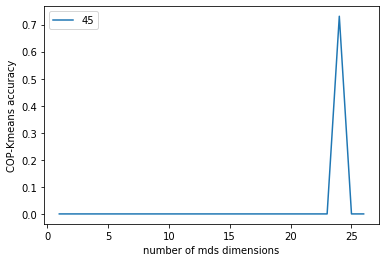

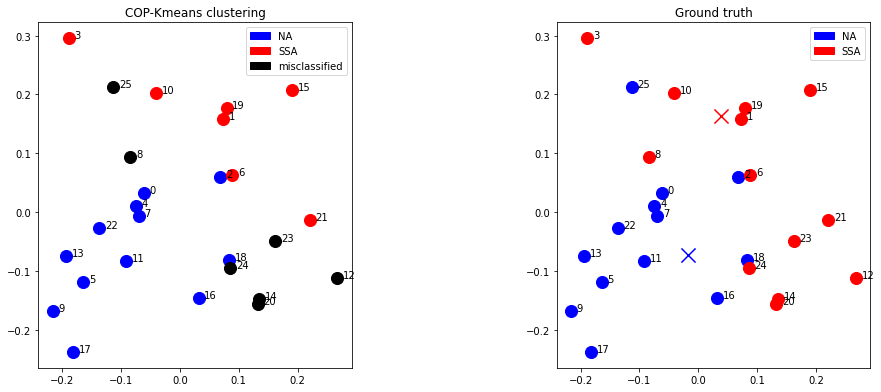

In [84]:
# Show results

def clusterCenters():
    center0 = np.mean(copkmeans_result.best_points[copkmeans_result.label==0],axis=0)
    center1 = np.mean(copkmeans_result.best_points[copkmeans_result.label==1],axis=0)
    return center0, center1

if (compute):
    if (random_init==False):
        copkmeans_result.clusteringAccuracyWithDimension()
    copkmeans_result.twoClustersMethodResult()
    copkmeans_result.showResultMap()
    plotPoints(copkmeans_result.best_points)
    #plt.scatter(copkmeans.init[:,0],copkmeans.init[:,1],s=200,marker='x') # if t-SNE and 1 coef
    center0, center1 = clusterCenters()
    plt.scatter(center0[0],center0[1],s=200,marker='x',color='blue') # if t-SNE and 1 coef
    plt.scatter(center1[0],center1[1],s=200,marker='x',color='red') # if t-SNE and 1 coef

    print("DB index : %f " %copkmeans_result.dbScore())
    if 'COP-Kmeans' not in methodUsed:
        accuracyVect = np.append(accuracyVect,copkmeans_result.best_accuracy)
        SCVect = np.append(SCVect,copkmeans_result.SC)
        methodUsed = np.append(methodUsed,'COP-Kmeans')
        prior = np.append(prior,('t-SNE')*(copkmeans_result.best_dim==7)+('PCoA '+str(copkmeans_result.best_dim))*(copkmeans_result.best_dim<7))

In [85]:
nRun = 10
copkmeans_result.probaLabel = np.zeros_like(sslLabel)

#method = 'closest to cluster center'
method = 'farthest from other cluster center'
method = 'mixed'

copkmeans_result = MapMethodResults("COP-Kmeans",random_init)
for i in range(nRun):
    print(str(int(i*100/nRun)) + "%")
    sslLabel = -1*np.ones(N)
    SemiSLAccuracy = -1*np.zeros(N)

    for p in range(N):
        must_link,cannot_link = linkSemi(sslLabel)
        copkmeans = COPKmeans(n_clusters=2,must_link=must_link,cannot_link=cannot_link,n_init=1000*(p==0)+1)
        copkmeans_result.applyMethod(copkmeans,dim=[-2],verbose=False) # 2D max I think, otherwise curse of dimensionnality
        nb = np.max([np.sum(copkmeans_result.label==0),np.sum(copkmeans_result.label==1)])
        for k in range(1,nb+1):
            NAToLabel,SSAToLabel = bestClassified(copkmeans_result,k,method)
            if ((np.max(sslLabel[NAToLabel][(k-1)%len(NAToLabel)])!=-1 and np.max(sslLabel[SSAToLabel][(k-1)%len(SSAToLabel)])!=-1)==False):
                break
        sslLabel[NAToLabel] = 0
        sslLabel[SSAToLabel] = 1
        SemiSLAccuracy[p] = np.max(copkmeans_result.accuracy)

    copkmeans_result.probaLabel += sslLabel/nRun
    if (nRun == 1):
        plt.plot(SemiSLAccuracy)

print(copkmeans_result.probaLabel)
copkmeans_result.label = np.where(copkmeans_result.probaLabel<0.5,0,1)
print(copkmeans_result.label)
'''
label = self.reverseLabel(label)
'''
acc = sum(condition==copkmeans_result.label)/N
if (acc<0.5):
    copkmeans_result.label = 1-copkmeans_result.label
    copkmeans_result.accuracy[0,0] = 1-acc
else:
    copkmeans_result.accuracy[0,0] = acc

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
[0.2 1.  1.  0.5 0.  0.  1.  0.  0.5 0.  0.6 0.  0.9 0.  0.6 1.  0.2 0.
 0.6 1.  0.5 1.  0.  1.  0.5 0.5]
[0 1 1 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 1 1 1 1 0 1 1 1]


In [86]:
copkmeans_result.twoClustersMethodResult()


copkmeans_result.label = np.where(copkmeans_result.probaLabel<0.5,0,1)
print(copkmeans_result.label)

Results

Best dimension -2 (7 means t-SNE)
Best normalisation 45 
Found clusters 
[0 1 1 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 1 1 1 1 0 1 1 1]
True clusters 
[0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1 0]
Well classified
[ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 23 24]
Wrong classified
[ 2 18 25]
Best COP-Kmeans accuracy : 0.884615
Silhouette coefficient : 0.368
[0 1 1 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 1 1 1 1 0 1 1 1]


## Comparing accuracy and silhouette coefficient

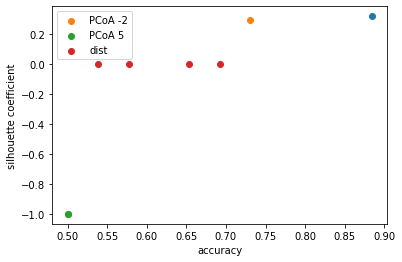

In [87]:
for meth in np.unique(prior):
    plt.scatter(accuracyVect[prior==meth],SCVect[prior==meth],label=meth) # Hard to compare MDS results because of random init

plt.xlabel("accuracy")
plt.ylabel("silhouette coefficient")
plt.legend()
plt.show()

## Strength of classification

In [123]:
steepness = np.genfromtxt(os.path.join('%s steepness.csv' %case),delimiter=';')
steepness = np.array(steepness,dtype='float') # Convert into array

if (case=="EEG"):
    tmpNA = steepness[narrative,0] - steepness[narrative,1]
    tmpSSA = steepness[stimulus,1] - steepness[stimulus,0]
    steepness = np.zeros(N)
    steepness[narrative] = tmpNA
    steepness[stimulus] = tmpSSA
else:
    idx = np.argsort(steepness[:,0])
    steepness = steepness[idx,1]
    
misClassifiedIvo = subjects[steepness<0]
steepness[stimulus] = -steepness[stimulus]
oppositeSteepness = True

print(misClassifiedIvo)

[18]


In [124]:
distance_matrix = computeDistanceMatrix(1,addCoef=0,keepDiag=True)
points = computePCoACoordinate(distance_matrix,2)
points3D = np.zeros((N,3))
points3D[:,:2] = points
points3D[:,2] = steepness

R2 score 0.800353


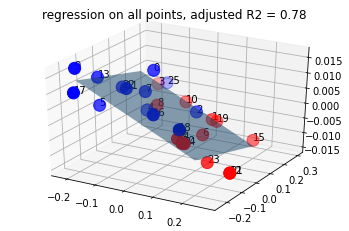

In [125]:
from sklearn.linear_model import LinearRegression

#ax = plt.axes([1.2,0,1.2,1.2])
#ax.set_aspect(aspect='equal')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(len(points)):
    ax.text(points3D[i,0],points3D[i,1],points3D[i,2],str(i))

ax.scatter(points3D[narrative,0],points3D[narrative,1],points3D[narrative,2],color='blue',s=145,label='NA')
ax.scatter(points3D[stimulus,0],points3D[stimulus,1],points3D[stimulus,2],color='red',s=145,label='SSA')

#misClassifiedIvo = 18
ax.scatter(points3D[misClassifiedIvo,0],points3D[misClassifiedIvo,1],points3D[misClassifiedIvo,2],color='black',s=145,label='misclassified')

regr = LinearRegression()
regr.fit(points, steepness)

ax.plot_surface(np.array([[-0.2, -0.2], [0.2,0.2]]),
                    np.array([[-0.2, 0.2], [-0.2, 0.2]]),
                    regr.predict(np.array([[-0.2, -0.2, 0.2, 0.2],
                                          [-0.2, 0.2, -0.2, 0.2]]).T
                                ).reshape((2, 2)),
                    alpha=.5)
'''
# horizontal plane z=0
ax.plot_surface(np.array([[-2, -2], [2, 2]]),
                    np.array([[-2, 2], [-2, 2]]),
                    np.zeros((2,2)),
                    alpha=.5)
'''

# Adjusted R2
R2 = 1 - (1-regr.score(points, steepness))*(len(steepness)-1)/(len(steepness)-points.shape[1]-1)
plt.title('regression on all points, adjusted R2 = %.2f' %R2)

print("R2 score %f" %regr.score(points,steepness))

plt.axis('tight')
plt.show()

In [128]:
if (oppositeSteepness):
    steepness[stimulus] = -steepness[stimulus]
    points3D[:,2] = steepness
    oppositeSteepness = False

[ 1.26589090e-02  4.61409056e-03  6.28219722e-04  9.90910259e-04
  3.04083575e-05  3.71380259e-03  6.76578920e-03  6.73432320e-03
  8.08960340e-04  1.59738313e-02  1.99411237e-03  9.40302887e-03
  1.06484382e-02  1.10733786e-02  2.38653947e-03  1.09894475e-02
  4.92089732e-03  1.07047033e-02 -8.21172729e-04  5.68041390e-03
  2.03075127e-03  1.46043087e-02  7.60338452e-03  1.11995781e-02
  3.36671026e-03  2.88363230e-03]


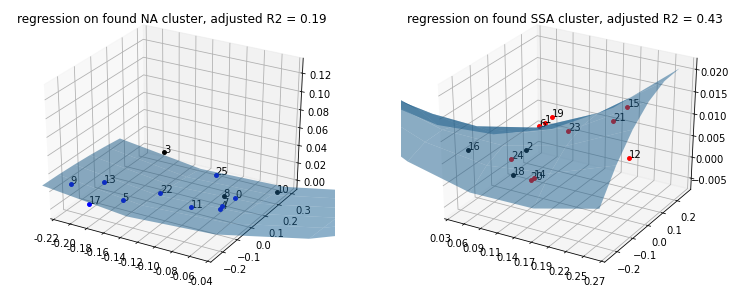

<Figure size 432x288 with 0 Axes>

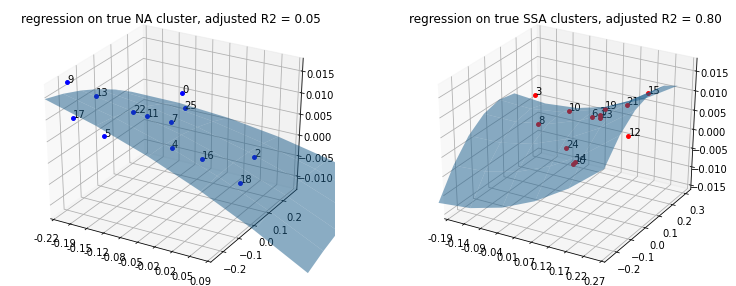

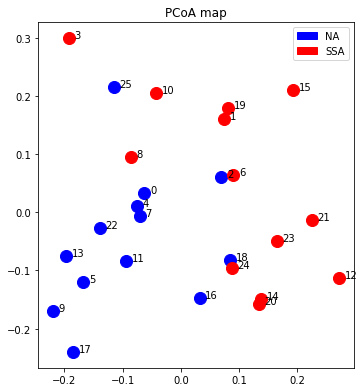

In [129]:
from sklearn.preprocessing import PolynomialFeatures
from matplotlib.ticker import LinearLocator, FormatStrFormatter

print(steepness)
def fitPolynome(degree,NA,SSA,ax,groupLabel):
    if (groupLabel==0):
        group = NA
        idealGroup = narrative
    else:
        group = SSA
        idealGroup = stimulus
    for i in group:
        ax.text(points3D[i,0],points3D[i,1],points3D[i,2],str(i))
        if i in idealGroup:
            ax.scatter(points3D[i,0],points3D[i,1],points3D[i,2],color='blue'*(np.array_equal(group,NA))+'red'*(np.array_equal(group,SSA)),s=15)
        else:
            ax.scatter(points3D[i,0],points3D[i,1],points3D[i,2],color='black',s=15)

    poly_reg = PolynomialFeatures(degree=degree)
    X_poly = poly_reg.fit_transform(points[group])
    pol_reg = LinearRegression()
    pol_reg.fit(X_poly, steepness[group])

    X = np.arange(np.min(points), np.max(points), 0.1)
    Y = np.arange(np.min(points), np.max(points), 0.1)

    X, Y = np.meshgrid(X, Y)

    toFit = np.zeros((len(X)*len(Y),2))
    toFit[:,0] = np.ravel(X)
    toFit[:,1] = np.ravel(Y)
    #X, Y = np.meshgrid(points[:,0], points[:,1])
    #toFit = points
    reg = pol_reg.predict(poly_reg.fit_transform(toFit))
    reg = reg.reshape((len(X), len(Y)))

    ax.plot_surface(X, Y, reg, alpha=.5)

    # Customize the x axis.
    ax.set_xlim(np.min(points[group,0]), np.max(points[group,0]))
    ax.xaxis.set_major_locator(LinearLocator(10))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    #return pol_reg.score(X_poly,steepness[group])
    # Adjusted R2
    return 1 - (1-pol_reg.score(X_poly, steepness[group]))*(len(group)-1)/(len(group)-X_poly.shape[1]-1)

  
    
NA = subjects[kmeans_result.label==0]
SSA = subjects[kmeans_result.label==1]

degree = 2
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,3,1, projection='3d')
R2 = fitPolynome(degree,NA,SSA,ax,0)
plt.title('regression on found NA cluster, adjusted R2 = %.2f' %R2)
ax = fig.add_subplot(1,3,2, projection='3d')
R2 = fitPolynome(degree,NA,SSA,ax,1)
plt.title('regression on found SSA cluster, adjusted R2 = %.2f' %R2)
plt.figure()
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,3,1, projection='3d')
R2 = fitPolynome(degree,narrative,stimulus,ax,0)
plt.title('regression on true NA cluster, adjusted R2 = %.2f' %R2)
ax = fig.add_subplot(1,3,2, projection='3d')
R2 = fitPolynome(degree,narrative,stimulus,ax,1)
plt.title('regression on true SSA clusters, adjusted R2 = %.2f' %R2)
plt.figure()
plotPoints(points,title='PCoA map')